# Σ-Semantic Normal Form — Computational Validation Suite

- Self-contained notebook; no external module imports required.
- Results: per-section PASS/FAIL, numerical summaries, figures, JSON report.

In [1]:
# Common imports and base types
from dataclasses import dataclass
from typing import Dict, List, Sequence, Tuple
from pathlib import Path
from itertools import permutations
import json
import time

import numpy as np

try:
    import matplotlib.pyplot as plt
except Exception:  # pragma: no cover
    plt = None


In [2]:
# Core math utilities (standalone)
Partition = Dict[int, str]




def build_fibers(partition: Partition, n_states: int) -> Dict[str, List[int]]:
    labels = sorted(set(partition.values()))
    fibers: Dict[str, List[int]] = {label: [] for label in labels}
    for s in range(n_states):
        fibers[partition[s]].append(s)
    return fibers


def block_pushforward(P: np.ndarray, partition: Partition, state: int) -> np.ndarray:
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, P.shape[0])
    return np.array([P[state, fibers[label]].sum() for label in labels], dtype=float)


def block_sum_spread(P: np.ndarray, partition: Partition) -> float:
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    labels = sorted(fibers.keys())
    max_diff = 0.0

    for label, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                for t_label in labels:
                    t_states = fibers[t_label]
                    diff = abs(P[i, t_states].sum() - P[j, t_states].sum())
                    max_diff = max(max_diff, diff)
    return float(max_diff)


def tv_violation(P: np.ndarray, partition: Partition) -> float:
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    max_tv = 0.0

    for label, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                p_i = block_pushforward(P, partition, i)
                p_j = block_pushforward(P, partition, j)
                tv = 0.5 * np.abs(p_i - p_j).sum()
                max_tv = max(max_tv, tv)
    return float(max_tv)


def check_sigma_w(P: np.ndarray, partition: Partition, tol: float = 1e-10) -> Tuple[bool, float]:
    spread = block_sum_spread(P, partition)
    return (spread <= tol), spread


def softmax_rows(theta: np.ndarray) -> np.ndarray:
    shifted = theta - theta.max(axis=1, keepdims=True)
    e = np.exp(shifted)
    return e / e.sum(axis=1, keepdims=True)


def theta_from_P(P: np.ndarray, eps: float = 1e-15) -> np.ndarray:
    return np.log(np.maximum(P, eps))


def numerical_gradient(loss_fn, theta: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    grad = np.zeros_like(theta)
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            theta[i, j] += eps
            fp = loss_fn(theta)
            theta[i, j] -= 2.0 * eps
            fm = loss_fn(theta)
            theta[i, j] += eps
            grad[i, j] = (fp - fm) / (2.0 * eps)
    return grad


def make_strong_sigma(partition: Partition, P_hat: np.ndarray) -> np.ndarray:
    n = len(partition)
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, n)
    P = np.zeros((n, n), dtype=float)

    for i in range(n):
        b_i = labels.index(partition[i])
        for j in range(n):
            b_j = labels.index(partition[j])
            P[i, j] = P_hat[b_i, b_j] / len(fibers[labels[b_j]])
    return P


def make_weak_sigmaw(partition: Partition, P_hat: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    n = len(partition)
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, n)
    P = np.zeros((n, n), dtype=float)

    for i in range(n):
        b_i = labels.index(partition[i])
        for b_j, label in enumerate(labels):
            states = fibers[label]
            w = rng.dirichlet(np.ones(len(states)))
            for k, s in enumerate(states):
                P[i, s] = P_hat[b_i, b_j] * w[k]
    return P


def compute_lumped_chain(P: np.ndarray, partition: Partition) -> np.ndarray:
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, P.shape[0])
    m = len(labels)
    out = np.zeros((m, m), dtype=float)

    for i, l_from in enumerate(labels):
        for j, l_to in enumerate(labels):
            vals = [P[s, fibers[l_to]].sum() for s in fibers[l_from]]
            out[i, j] = float(np.mean(vals))
    return out


def sigmaw_symmetric_loss_factory(partition: Partition, target_hat: np.ndarray):
    def loss_fn(P: np.ndarray) -> float:
        P_hat = compute_lumped_chain(P, partition)
        return float(((P_hat - target_hat) ** 2).sum())

    return loss_fn


def gamma_from_theta_grad(theta: np.ndarray, grad: np.ndarray, partition: Dict[int, str]) -> float:
    """Compute Prop 4.4 first-order degradation gamma from precomputed gradient."""
    P0 = softmax_rows(theta)
    labels = sorted(set(partition.values()))
    fibers = {label: [s for s in range(P0.shape[0]) if partition[s] == label] for label in labels}

    G_bar = (P0 * grad).sum(axis=1)
    A = np.zeros((P0.shape[0], len(labels)), dtype=float)

    for s_idx, label in enumerate(labels):
        for k in fibers[label]:
            A[:, s_idx] += P0[:, k] * (grad[:, k] - G_bar)

    gamma = 0.0
    for label in labels:
        states = fibers[label]
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                gamma = max(gamma, np.abs(A[i] - A[j]).max())
    return float(gamma)


def degradation_rate_gamma(theta: np.ndarray, loss_fn_P, partition: Partition) -> float:
    """Wrapper: computes gradient internally, then delegates to gamma_from_theta_grad."""
    grad = numerical_gradient(lambda th: loss_fn_P(softmax_rows(th)), theta)
    return gamma_from_theta_grad(theta, grad, partition)


def spectral_residual_sequence(P_hat: np.ndarray, mu0: np.ndarray, T: int) -> np.ndarray:
    traj = [mu0.copy()]
    mu = mu0.copy()
    for _ in range(T):
        mu = mu @ P_hat
        traj.append(mu.copy())
    traj = np.array(traj)
    return traj[1:] - traj[:-1]




def compute_D_NBC(P: np.ndarray, partition: Dict[int, str]) -> float:
    # Non-block-constancy deviation: max_{i,j in same fiber} ||P_i - P_j||_inf
    labels = sorted(set(partition.values()))
    fibers = {l: [s for s in range(P.shape[0]) if partition[s] == l] for l in labels}
    d_val = 0.0
    for l in labels:
        states = fibers[l]
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                d_val = max(d_val, float(np.max(np.abs(P[states[i_idx]] - P[states[j_idx]]))))
    return float(d_val)


def block_spread_structural(P: np.ndarray, partition: Dict[int, str]) -> float:
    # Spread definition for near-closure analysis
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, P.shape[0])
    max_spread = 0.0
    for fiber_label, states in fibers.items():
        for target_label in labels:
            vals = [float(P[s, fibers[target_label]].sum()) for s in states]
            max_spread = max(max_spread, max(vals) - min(vals))
    return float(max_spread)


## Common Helper Functions
`SectionResult` dataclass and partition / kernel / gradient / spectral utilities.

In [3]:
# Extended helpers for base 14 sections + reinforcement sections
@dataclass
class SectionResult:
    name: str
    passed: bool
    notes: Dict[str, object]


def _to_builtin(x):
    if isinstance(x, complex):
        return {"real": float(np.real(x)), "imag": float(np.imag(x))}
    if isinstance(x, np.generic):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {str(k): _to_builtin(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [_to_builtin(v) for v in x]
    return x


def _labels(n_blocks: int) -> List[str]:
    if n_blocks <= 26:
        return [chr(ord("A") + i) for i in range(n_blocks)]
    return [f"B{i}" for i in range(n_blocks)]


def balanced_partition(n_states: int, n_blocks: int) -> Dict[int, str]:
    labels = _labels(n_blocks)
    return {i: labels[i % n_blocks] for i in range(n_states)}


def random_partition(n_states: int, n_blocks: int, rng: np.random.Generator) -> Dict[int, str]:
    labels = _labels(n_blocks)
    while True:
        assign = rng.integers(0, n_blocks, size=n_states)
        used = set(int(x) for x in assign)
        if len(used) == n_blocks:
            break
    return {i: labels[int(assign[i])] for i in range(n_states)}


def random_stochastic(n: int, rng: np.random.Generator) -> np.ndarray:
    return np.vstack([rng.dirichlet(np.ones(n)) for _ in range(n)])


def compose_partition(partition: Dict[int, str], psi: Dict[str, str]) -> Dict[int, str]:
    return {i: psi[partition[i]] for i in partition}


def longest_window(vals: Sequence[float], threshold: float) -> int:
    best = 0
    cur = 0
    for v in vals:
        if v >= threshold:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return best


def stationary_distribution(P: np.ndarray) -> np.ndarray:
    vals, vecs = np.linalg.eig(P.T)
    idx = int(np.argmin(np.abs(vals - 1.0)))
    v = np.real(vecs[:, idx])
    v = np.maximum(v, 0.0)
    if v.sum() <= 0:
        v = np.abs(np.real(vecs[:, idx]))
    return v / v.sum()


def semantic_trajectory(P_hat: np.ndarray, mu0: np.ndarray, T: int) -> np.ndarray:
    traj = np.zeros((T + 1, len(mu0)), dtype=float)
    traj[0] = mu0
    for t in range(T):
        traj[t + 1] = traj[t] @ P_hat
    return traj


def residuals_from_traj(mu_traj: np.ndarray) -> np.ndarray:
    return mu_traj[1:] - mu_traj[:-1]


def half_life_from_curve(curve: np.ndarray, ratio: float = 0.5) -> int:
    if len(curve) == 0:
        return 0
    base = float(curve[0])
    if base <= 0:
        return 0
    idx = np.where(curve <= ratio * base)[0]
    return int(idx[0]) if len(idx) > 0 else len(curve) - 1


def evaluate_sigma_plus_flags(
    P_hat: np.ndarray,
    mu0: np.ndarray,
    T: int = 120,
    eps: float = 1e-8,
    rho: float = 0.0,
    delta: float = 0.01,
) -> Dict[str, object]:
    """Finite-state evaluator for Sigma+ axes used in supplement-style tests."""
    traj = semantic_trajectory(P_hat, mu0, T)
    R = residuals_from_traj(traj)
    rnorm = np.linalg.norm(R, axis=1)

    # Sigma+-1
    plus1 = bool(np.max(rnorm) > eps)
    active_window = int(np.sum(rnorm > eps))

    # Sigma+-2
    cosines: List[float] = []
    for t in range(len(R) - 1):
        denom = np.linalg.norm(R[t]) * np.linalg.norm(R[t + 1])
        if denom > 1e-14:
            cosines.append(float(np.dot(R[t], R[t + 1]) / denom))
    coh_window = longest_window(cosines, threshold=rho)
    plus2 = bool(coh_window >= 2)

    # Sigma+-3 (basis pair separation over n>=1)
    n_s = P_hat.shape[0]
    sep_curve = np.zeros(T + 1, dtype=float)
    for n in range(T + 1):
        best = 0.0
        for i in range(n_s):
            mu_i = np.zeros(n_s, dtype=float)
            mu_i[i] = 1.0
            for j in range(i + 1, n_s):
                mu_j = np.zeros(n_s, dtype=float)
                mu_j[j] = 1.0
                tr_i = semantic_trajectory(P_hat, mu_i, n)
                tr_j = semantic_trajectory(P_hat, mu_j, n)
                best = max(best, float(np.linalg.norm(tr_i[-1] - tr_j[-1])))
        sep_curve[n] = best
    max_sep_post = float(np.max(sep_curve[1:])) if len(sep_curve) > 1 else 0.0
    plus3 = bool(max_sep_post >= delta)

    return {
        "plus1": plus1,
        "plus2": plus2,
        "plus3": plus3,
        "active_window": active_window,
        "coherence_window": coh_window,
        "max_sep_post": max_sep_post,
        "cosines": np.array(cosines, dtype=float),
    }


def semantic_distribution_sequence_from_micro(
    P: np.ndarray,
    partition: Dict[int, str],
    mu0_semantic: np.ndarray,
    T: int,
) -> np.ndarray:
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, P.shape[0])
    m = len(labels)

    mu0 = np.array(mu0_semantic, dtype=float)
    mu0 = np.maximum(mu0, 0.0)
    mu0 = mu0 / max(mu0.sum(), 1e-15)

    mu_z = np.zeros(P.shape[0], dtype=float)
    for s_idx, label in enumerate(labels):
        states = fibers[label]
        if len(states) > 0:
            mu_z[states] = mu0[s_idx] / len(states)

    traj = np.zeros((T + 1, m), dtype=float)
    for t in range(T + 1):
        for s_idx, label in enumerate(labels):
            traj[t, s_idx] = float(mu_z[fibers[label]].sum())
        if t < T:
            mu_z = mu_z @ P
    return traj


def evaluate_sigma_plus_from_semantic_process(
    P: np.ndarray,
    partition: Dict[int, str],
    mu0_semantic: np.ndarray,
    T: int = 120,
    eps: float = 1e-8,
    rho: float = 0.0,
    delta: float = 0.01,
) -> Dict[str, object]:
    """Evaluate Sigma+ directly on S_t = Sigma(Z_t), without Markov lumping assumptions."""
    labels = sorted(set(partition.values()))
    m = len(labels)

    traj = semantic_distribution_sequence_from_micro(P, partition, mu0_semantic, T)
    R = residuals_from_traj(traj)
    rnorm = np.linalg.norm(R, axis=1)

    cosines = []
    for t in range(len(R) - 1):
        denom = np.linalg.norm(R[t]) * np.linalg.norm(R[t + 1])
        if denom > 1e-14:
            cosines.append(float(np.dot(R[t], R[t + 1]) / denom))
    coh_window = longest_window(cosines, threshold=rho)

    sep_curve = np.zeros(T + 1, dtype=float)
    for n in range(T + 1):
        best = 0.0
        for i in range(m):
            mu_i = np.zeros(m, dtype=float)
            mu_i[i] = 1.0
            tr_i = semantic_distribution_sequence_from_micro(P, partition, mu_i, n)
            for j in range(i + 1, m):
                mu_j = np.zeros(m, dtype=float)
                mu_j[j] = 1.0
                tr_j = semantic_distribution_sequence_from_micro(P, partition, mu_j, n)
                best = max(best, float(np.linalg.norm(tr_i[-1] - tr_j[-1])))
        sep_curve[n] = best

    max_sep_post = float(np.max(sep_curve[1:])) if len(sep_curve) > 1 else 0.0
    return {
        'plus1': bool(np.max(rnorm) > eps),
        'plus2': bool(coh_window >= 2),
        'plus3': bool(max_sep_post >= delta),
        'active_window': int(np.sum(rnorm > eps)),
        'coherence_window': int(coh_window),
        'max_sep_post': float(max_sep_post),
        'cosines': np.array(cosines, dtype=float),
    }


def partition_to_onehot(partition: Dict[int, str], labels: Sequence[str]) -> np.ndarray:
    n = len(partition)
    lab_to_idx = {lab: i for i, lab in enumerate(labels)}
    A = np.zeros((n, len(labels)), dtype=float)
    for i in range(n):
        A[i, lab_to_idx[partition[i]]] = 1.0
    return A


def soft_sigmaw_violation(P: np.ndarray, A: np.ndarray, eps: float = 1e-15) -> float:
    """Definition 4.11 style soft SigmaW violation."""
    A = np.array(A, dtype=float)
    A = np.maximum(A, eps)
    A = A / np.maximum(A.sum(axis=1, keepdims=True), eps)

    Y = P @ A
    total = 0.0
    for s in range(A.shape[1]):
        w = A[:, s]
        wsum = float(w.sum())
        if wsum <= eps:
            continue
        w = w / wsum
        mean = np.sum(w[:, None] * Y, axis=0)
        var = np.sum(w[:, None] * (Y - mean) ** 2, axis=0)
        total += float(np.sum(var))
    return float(total)


def _best_hamming_up_to_permutation(pred: np.ndarray, target: np.ndarray) -> int:
    pred = np.array(pred, dtype=int)
    target = np.array(target, dtype=int)
    m = int(max(int(np.max(pred)), int(np.max(target))) + 1)
    best = pred.shape[0] + 1
    for perm in permutations(range(m)):
        mapped = np.array([perm[int(x)] for x in pred], dtype=int)
        best = min(best, int(np.sum(mapped != target)))
    return int(best)


def optimize_soft_partition(
    P: np.ndarray,
    theta0: np.ndarray,
    n_steps: int,
    lr: float,
    alpha_prior: float = 0.0,
    A_prior: np.ndarray | None = None,
) -> Tuple[np.ndarray, np.ndarray]:
    theta = np.array(theta0, dtype=float).copy()
    losses = []

    def loss_theta(th: np.ndarray) -> float:
        A = softmax_rows(th)
        val = soft_sigmaw_violation(P, A)
        if alpha_prior > 0.0 and A_prior is not None:
            val += float(alpha_prior * np.sum((A - A_prior) ** 2))
        return float(val)

    for _ in range(int(n_steps)):
        losses.append(float(loss_theta(theta)))
        g = numerical_gradient(loss_theta, theta)
        theta = theta - float(lr) * g

    return softmax_rows(theta), np.array(losses, dtype=float)


def finite_state_theorem51_sampler(
    P: np.ndarray,
    partition: Dict[int, str],
    rng: np.random.Generator,
    n_samples: int,
) -> Tuple[np.ndarray, int]:
    """Finite constructive witness for Theorem 5.1 style realization.

    Build a sampler F(z, r0, r1) by:
    1) sample semantic next state from induced P_hat
    2) sample micro next state from fiber-conditional q(z, s')

    Returns empirical transition matrix and compatibility violations.
    """
    labels = sorted(set(partition.values()))
    fibers = {l: [i for i in range(P.shape[0]) if partition[i] == l] for l in labels}
    lab_to_idx = {l: i for i, l in enumerate(labels)}

    P_hat = compute_lumped_chain(P, partition)
    q = np.zeros((P.shape[0], len(labels), P.shape[0]), dtype=float)

    for i in range(P.shape[0]):
        for b_idx, b in enumerate(labels):
            target_states = fibers[b]
            mass = float(P[i, target_states].sum())
            if mass > 1e-15:
                q[i, b_idx, target_states] = P[i, target_states] / mass
            else:
                q[i, b_idx, target_states] = 1.0 / len(target_states)

    emp = np.zeros_like(P)
    compat_fail = 0

    for i in range(P.shape[0]):
        s_i = partition[i]
        s_idx = lab_to_idx[s_i]
        for _ in range(n_samples):
            b_next = int(rng.choice(len(labels), p=P_hat[s_idx]))
            j = int(rng.choice(P.shape[0], p=q[i, b_next]))
            emp[i, j] += 1.0
            if labels[b_next] != partition[j]:
                compat_fail += 1

    emp = emp / emp.sum(axis=1, keepdims=True)
    return emp, compat_fail


In [4]:
PROFILE_CONFIGS = {
    'mode1': {
        # --- Base sections (Prop 4.1 ~ Adapter B.1, Supplement) ---
        'prop41_trials': 180,
        'genericity_trials': 80,
        'grad_trials': 10,
        'grad_steps': 14,
        'prop44_trials': 8,
        'prop44_steps': 18,
        'prop45_samples': 120,
        'thm51_samples': 30000,
        'supp_chains_per_n': 500,
        'supp_partitions_per_chain': 50,
        'supp_large_trials': 949,
        'supp_scale_Ns': [6, 10, 20, 30],
        'supp_scale_blocks': [2, 5, 10],
        'supp_scale_repeats': 1,
        # --- Extra sections (boundary, near-closure, etc.) ---
        'boundary_chains': 200,
        'boundary_partitions': 20,
        'near_closure_trials': 1500,
        'perturb_eps_count': 25,
        'perturb_samples_per_eps': 80,
        'dnbc_alpha_points': 16,
        'gamma_batch_Ns': [6, 10, 20, 30, 50],
        'scale_Ns': [6, 10, 20, 30, 50, 80, 100],
        'scale_Ns_grad': [6, 10, 20, 30, 50, 80, 100],
        'scale_Ns_gamma': [6, 10, 20, 30, 50],
        'sigma_plus_opt_steps': 180,
        'sigma_plus_eval_interval': 10,
        'sigma_plus_T': 60,
        'discover_trials': 20,
        'discover_steps': 120,
        'discover_attractor_grid': 11,
        'remark_non_attractor_inits': 10,
        'remark_non_attractor_T': 100,
        'remark_alpha_T': 200,
        'remark_nonsw_T': 500,
    },
    'mode2': {
        # --- Base sections ---
        'prop41_trials': 240,
        'genericity_trials': 120,
        'grad_trials': 12,
        'grad_steps': 16,
        'prop44_trials': 10,
        'prop44_steps': 24,
        'prop45_samples': 200,
        'thm51_samples': 50000,
        'supp_chains_per_n': 500,
        'supp_partitions_per_chain': 50,
        'supp_large_trials': 949,
        'supp_scale_Ns': [6, 10, 20, 30, 50],
        'supp_scale_blocks': [2, 5, 10],
        'supp_scale_repeats': 2,
        # --- Extra sections ---
        'boundary_chains': 350,
        'boundary_partitions': 35,
        'near_closure_trials': 3000,
        'perturb_eps_count': 40,
        'perturb_samples_per_eps': 140,
        'dnbc_alpha_points': 25,
        'gamma_batch_Ns': [6, 10, 20, 30, 50, 80, 100, 150],
        'scale_Ns': [6, 10, 20, 30, 50, 80, 100, 150],
        'scale_Ns_grad': [6, 10, 20, 30, 50, 80, 100, 150],
        'scale_Ns_gamma': [6, 10, 20, 30, 50, 80, 100, 150],
        'sigma_plus_opt_steps': 240,
        'sigma_plus_eval_interval': 10,
        'sigma_plus_T': 80,
        'discover_trials': 20,
        'discover_steps': 140,
        'discover_attractor_grid': 15,
        'remark_non_attractor_inits': 10,
        'remark_non_attractor_T': 100,
        'remark_alpha_T': 200,
        'remark_nonsw_T': 500,
    },
    'mode3': {
        # --- Base sections ---
        'prop41_trials': 400,
        'genericity_trials': 140,
        'grad_trials': 14,
        'grad_steps': 18,
        'prop44_trials': 12,
        'prop44_steps': 30,
        'prop45_samples': 260,
        'thm51_samples': 70000,
        'supp_chains_per_n': 500,
        'supp_partitions_per_chain': 50,
        'supp_large_trials': 949,
        'supp_scale_Ns': [6, 10, 20, 30, 50, 80, 100],
        'supp_scale_blocks': [2, 5, 10],
        'supp_scale_repeats': 1,
        # --- Extra sections ---
        'boundary_chains': 500,
        'boundary_partitions': 50,
        'near_closure_trials': 5000,
        'perturb_eps_count': 50,
        'perturb_samples_per_eps': 200,
        'dnbc_alpha_points': 30,
        'gamma_batch_Ns': [6, 10, 20, 30, 50, 80, 100],
        'scale_Ns': [6, 10, 20, 30, 50, 80, 100, 150, 200],
        'scale_Ns_grad': [6, 10, 20, 30, 50, 80, 100],
        'scale_Ns_gamma': [6, 10, 20, 30, 50, 80, 100],
        'sigma_plus_opt_steps': 300,
        'sigma_plus_eval_interval': 10,
        'sigma_plus_T': 100,
        'discover_trials': 20,
        'discover_steps': 180,
        'discover_attractor_grid': 21,
        'remark_non_attractor_inits': 10,
        'remark_non_attractor_T': 100,
        'remark_alpha_T': 200,
        'remark_nonsw_T': 500,
    },
}


CLAIM_TOLERANCES = {
    'mode1': {
        'prop44_strict_applied': False,
        'prop44_abs_tol': 2e-5,
        'prop44_repeats': 1,
        'prop44_oper_slope_tol': 1e-3,
        'prop44_oper_ratio_tol': 1e-2,
        'prop44_oper_min_success_rate': 0.95,
        'prop46_sign_match_min': 1.0,
        'prop46_log_corr_min': 0.95,
        'prop46_half_life_mae_max': 3.0,
    },
    'mode2': {
        'prop44_strict_applied': False,
        'prop44_abs_tol': 2e-5,
        'prop44_repeats': 2,
        'prop44_oper_slope_tol': 7.5e-4,
        'prop44_oper_ratio_tol': 7.5e-3,
        'prop44_oper_min_success_rate': 0.95,
        'prop46_sign_match_min': 1.0,
        'prop46_log_corr_min': 0.95,
        'prop46_half_life_mae_max': 3.0,
    },
    'mode3': {
        'prop44_strict_applied': True,
        'prop44_abs_tol': 2e-5,
        'prop44_repeats': 3,
        'prop44_oper_slope_tol': 5e-4,
        'prop44_oper_ratio_tol': 5e-3,
        'prop44_oper_min_success_rate': 1.0,
        'prop46_sign_match_min': 1.0,
        'prop46_log_corr_min': 0.96,
        'prop46_half_life_mae_max': 2.0,
    },
}

In [5]:
# Validation configuration
# Change PROFILE to 'mode2' or 'mode3' for more thorough runs.
# Restart kernel before re-running to reset accumulated results.
SEED = 42
PROFILE = 'mode3'  # 'mode1' | 'mode2' | 'mode3'
cfg = PROFILE_CONFIGS[PROFILE]
_ALL_RESULTS: list = []


def print_result(result, claim=""):
    """Pretty-print a SectionResult for computational supplement output."""
    tag = "PASS" if result.passed else "FAIL"
    w = 64
    print(f"\n{'-' * w}")
    print(f"  {result.name}")
    if claim:
        print(f"  Claim: {claim}")
    print(f"{'-' * w}")
    for k, v in result.notes.items():
        if k == 'elapsed_sec':
            continue
        label = k.replace('_', ' ')
        if isinstance(v, float):
            print(f"  {label:<36s}  {v:.6g}")
        elif isinstance(v, bool):
            print(f"  {label:<36s}  {'Yes' if v else 'No'}")
        elif isinstance(v, np.ndarray):
            if v.size <= 8:
                print(f"  {label:<36s}  {v.tolist()}")
            else:
                print(f"  {label:<36s}  array(shape={v.shape})")
        elif isinstance(v, (list, tuple)) and len(v) <= 8:
            print(f"  {label:<36s}  {v}")
        else:
            vstr = str(v)
            if len(vstr) > 60:
                vstr = vstr[:57] + "..."
            print(f"  {label:<36s}  {vstr}")
    elapsed = result.notes.get('elapsed_sec')
    elapsed_str = f"  ({elapsed:.1f}s)" if elapsed else ""
    print(f"\n  [{tag}]{elapsed_str}")
    print(f"{'-' * w}")

## Prop 4.1 — Finite-State Reduction (B vs V Geometry)
§4.3.1. $\mathcal{B}_\Sigma \le \mathcal{V}_\Sigma \le \lfloor |S|/2 \rfloor\cdot\mathcal{B}_\Sigma$.


In [6]:
def section_prop41_geometry(seed: int, trials: int) -> Tuple[SectionResult, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    rows = []

    total = 0
    ok_bounds = 0
    ok_identity = 0

    configs = [(12, 2), (12, 3), (12, 4), (15, 5), (18, 6)]
    for n_states, n_blocks in configs:
        part = balanced_partition(n_states, n_blocks)
        for _ in range(trials):
            P = random_stochastic(n_states, rng)
            B = block_sum_spread(P, part)
            V = tv_violation(P, part)
            rows.append((n_blocks, B, V))
            total += 1

            ub = (n_blocks // 2) * B + 1e-12
            if B - 1e-12 <= V <= ub:
                ok_bounds += 1

            if n_blocks <= 3:
                if abs(V - B) <= 1e-10:
                    ok_identity += 1
            else:
                ok_identity += 1

    # Tightness witness on probability vectors for |S|=4,5.
    tight_ratios: Dict[str, float] = {}
    for m in [4, 5]:
        k = m // 2
        B = 0.1
        x = np.array([B] * k + [-B] * (m - k), dtype=float)
        # For odd m, rebalance last entry so sum(x)=0.
        x[-1] = -np.sum(x[:-1])
        u = np.ones(m, dtype=float) / m
        p = u + 0.5 * x
        q = u - 0.5 * x
        p = np.maximum(p, 1e-12)
        q = np.maximum(q, 1e-12)
        p = p / p.sum()
        q = q / q.sum()
        x2 = p - q
        B2 = float(np.max(np.abs(x2)))
        V2 = float(0.5 * np.abs(x2).sum())
        tight_ratios[f"m{m}"] = V2 / max(B2, 1e-15)

    arr = np.array(rows, dtype=float)
    Bs = arr[:, 1]
    Vs = arr[:, 2]

    passed = (
        ok_bounds == total
        and ok_identity == total
        and tight_ratios["m4"] >= 1.95
        and tight_ratios["m5"] >= 1.95
    )

    return (
        SectionResult(
            name="Prop 4.1 geometry and tightness",
            passed=passed,
            notes={
                "total_cases": total,
                "bounds_ok": ok_bounds,
                "identity_ok": ok_identity,
                "tight_ratio_m4": tight_ratios["m4"],
                "tight_ratio_m5": tight_ratios["m5"],
                "mean_V_over_B": float(np.mean(Vs[Bs > 1e-12] / Bs[Bs > 1e-12])),
            },
        ),
        Bs,
        Vs,
    )


In [7]:
_t0 = time.perf_counter()
_r, _, _ = section_prop41_geometry(SEED + 1, cfg["prop41_trials"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "B_Σ(P) ≤ V_Σ(P) ≤ ⌊|S|/2⌋·B_Σ(P) for all Σ, P")



----------------------------------------------------------------
  Prop 4.1 geometry and tightness
  Claim: B_Σ(P) ≤ V_Σ(P) ≤ ⌊|S|/2⌋·B_Σ(P) for all Σ, P
----------------------------------------------------------------
  total cases                           2000
  bounds ok                             2000
  identity ok                           2000
  tight ratio m4                        2
  tight ratio m5                        2
  mean V over B                         1.14498

  [PASS]  (1.0s)
----------------------------------------------------------------


## Examples E2 / E4 — Direct Verification
Appendix C. E2 (finite lumping) and E4 (open-system effective kernel).

In [8]:
def section_e2_e4_witnesses() -> SectionResult:
    a, b = 0.7, 0.3
    P_e2 = np.array(
        [
            [a, 0.0, 1.0 - a, 0.0],
            [0.0, a, 0.0, 1.0 - a],
            [b, 0.0, 1.0 - b, 0.0],
            [0.0, b, 0.0, 1.0 - b],
        ],
        dtype=float,
    )
    part_good = {0: "A", 1: "A", 2: "B", 3: "B"}
    part_bad = {0: "A", 1: "A", 2: "A", 3: "B"}

    e2_good, b_good = check_sigma_w(P_e2, part_good)
    e2_bad, b_bad = check_sigma_w(P_e2, part_bad)

    P0 = np.array(
        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0]], dtype=float
    )
    P1 = np.array(
        [[0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=float
    )
    P_eff = 0.5 * (P0 + P1)

    e4_0, _ = check_sigma_w(P0, part_good)
    e4_1, _ = check_sigma_w(P1, part_good)
    e4_eff, b_eff = check_sigma_w(P_eff, part_good)

    passed = (
        e2_good
        and (not e2_bad)
        and b_good <= 1e-10
        and b_bad > 1e-6
        and (not e4_0)
        and (not e4_1)
        and e4_eff
        and b_eff <= 1e-10
    )

    return SectionResult(
        name="E2/E4 finite witnesses",
        passed=passed,
        notes={
            "e2_good": e2_good,
            "e2_bad": e2_bad,
            "e2_good_B": float(b_good),
            "e2_bad_B": float(b_bad),
            "e4_conditional_fail": bool((not e4_0) and (not e4_1)),
            "e4_effective_hold": e4_eff,
            "e4_effective_B": float(b_eff),
        },
    )


In [9]:
_t0 = time.perf_counter()
_r = section_e2_e4_witnesses()
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Examples E2, E4 produce predicted ΣW witness behavior")


----------------------------------------------------------------
  E2/E4 finite witnesses
  Claim: Examples E2, E4 produce predicted ΣW witness behavior
----------------------------------------------------------------
  e2 good                               Yes
  e2 bad                                No
  e2 good B                             0
  e2 bad B                              0.3
  e4 conditional fail                   Yes
  e4 effective hold                     Yes
  e4 effective B                        0

  [PASS]
----------------------------------------------------------------


## ΣW Generic Failure (Measure Zero)
§4.3.1 Remark. ΣW satisfaction probability = 0 for random Markov chains.

In [10]:
def section_genericity(seed: int, trials_per_config: int) -> SectionResult:
    rng = np.random.default_rng(seed)
    hits = 0
    total = 0
    min_B = float("inf")

    for n_states in [6, 8, 10, 12]:
        for n_blocks in [2, 3, 4]:
            if n_blocks >= n_states:
                continue
            for _ in range(trials_per_config):
                P = random_stochastic(n_states, rng)
                part = random_partition(n_states, n_blocks, rng)
                ok, B = check_sigma_w(P, part)
                total += 1
                hits += int(ok)
                min_B = min(min_B, float(B))

    hit_rate = hits / max(total, 1)
    passed = hits == 0
    return SectionResult(
        name="Genericity stress (random chains)",
        passed=passed,
        notes={
            "total_trials": total,
            "sigmaw_hits": hits,
            "hit_rate": hit_rate,
            "min_B": min_B,
        },
    )


In [11]:
_t0 = time.perf_counter()
_r = section_genericity(SEED + 2, cfg["genericity_trials"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "ΣW-satisfying partitions form a measure-zero set")


----------------------------------------------------------------
  Genericity stress (random chains)
  Claim: ΣW-satisfying partitions form a measure-zero set
----------------------------------------------------------------
  total trials                          1680
  sigmaw hits                           0
  hit rate                              0
  min B                                 0.047559

  [PASS]  (0.2s)
----------------------------------------------------------------


## Prop 4.2 / 4.3 — ΣW Preservation vs Non-Preservation Under Gradient Descent
§4.3.2. Block-constant invariance (4.2) and weak ΣW non-preservation (4.3).

In [12]:
def section_prop42_prop43(seed: int, trials: int, steps: int) -> SectionResult:
    rng = np.random.default_rng(seed)

    max_B_strong_all = 0.0
    weak_drift = 0

    for _ in range(trials):
        part = balanced_partition(6, 2)
        P_hat_init = np.vstack([rng.dirichlet(np.ones(2)) for _ in range(2)])
        P_hat_target = np.vstack([rng.dirichlet(np.ones(2)) for _ in range(2)])
        loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

        # Strong start: should preserve B ~ 0.
        P_strong = make_strong_sigma(part, P_hat_init)
        th = theta_from_P(P_strong)
        max_B_local = 0.0

        for _ in range(steps):
            P = softmax_rows(th)
            B = block_sum_spread(P, part)
            max_B_local = max(max_B_local, B)
            g = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th)
            th = th - 0.05 * g

        max_B_strong_all = max(max_B_strong_all, max_B_local)

        # Weak start: generic one-step drift expected.
        P_weak = make_weak_sigmaw(part, P_hat_init, rng)
        th_w = theta_from_P(P_weak)
        B0 = block_sum_spread(P_weak, part)
        g_w = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th_w)
        P1 = softmax_rows(th_w - 0.05 * g_w)
        B1 = block_sum_spread(P1, part)
        if B1 > B0 + 1e-7:
            weak_drift += 1

    drift_rate = weak_drift / max(trials, 1)
    passed = (max_B_strong_all <= 1e-8) and (drift_rate >= 0.7)
    return SectionResult(
        name="Prop 4.2/4.3 gradient dynamics",
        passed=passed,
        notes={
            "trials": trials,
            "steps_per_strong_trial": steps,
            "max_B_strong": float(max_B_strong_all),
            "weak_drift_trials": weak_drift,
            "weak_drift_rate": float(drift_rate),
        },
    )


In [13]:
_t0 = time.perf_counter()
_r = section_prop42_prop43(SEED + 3, cfg["grad_trials"], cfg["grad_steps"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Strong-Σ gradient preserves ΣW; weak-Σ gradient may violate")


----------------------------------------------------------------
  Prop 4.2/4.3 gradient dynamics
  Claim: Strong-Σ gradient preserves ΣW; weak-Σ gradient may violate
----------------------------------------------------------------
  trials                                14
  steps per strong trial                18
  max B strong                          8.95928e-12
  weak drift trials                     14
  weak drift rate                       1

  [PASS]  (0.6s)
----------------------------------------------------------------


## Prop 4.4 + Cor 4.4.1 — Quantitative Degradation Rate
§4.3.2. $\mathcal{B}_\Sigma(P_1) = \eta\,D_\Sigma + O(\eta^2)$ first-order scaling.

In [14]:
def section_prop44_cor441(seed: int, trials: int, steps: int) -> Tuple[SectionResult, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    slopes = []
    ratios = []
    ms_ratios = []

    plot_etas = None
    plot_Bs = None

    for trial in range(trials):
        part = balanced_partition(6, 2)
        P_hat_init = np.vstack([rng.dirichlet(np.ones(2)) for _ in range(2)])
        P_hat_target = np.vstack([rng.dirichlet(np.ones(2)) for _ in range(2)])
        loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

        P_weak = make_weak_sigmaw(part, P_hat_init, rng)
        th0 = theta_from_P(P_weak)
        g0 = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th0)
        gamma0 = degradation_rate_gamma(th0, loss_fn, part)

        etas = np.logspace(-5, -2, 10)
        Bvals = []
        for eta in etas:
            P1 = softmax_rows(th0 - eta * g0)
            Bvals.append(block_sum_spread(P1, part))

        etas = np.array(etas)
        Bvals = np.array(Bvals)

        slope, _ = np.polyfit(np.log10(etas), np.log10(np.maximum(Bvals, 1e-20)), 1)
        ratio = float(Bvals[3] / (etas[3] * gamma0)) if gamma0 > 1e-14 else np.nan  # etas[3]=1e-4

        slopes.append(float(slope))
        ratios.append(ratio)

        if trial == 0:
            plot_etas = etas
            plot_Bs = Bvals

        # Cor 4.4.1 style cumulative behavior test.
        eta_ms = 1e-3
        th = th0.copy()
        B_t = [block_sum_spread(softmax_rows(th), part)]
        pred = [0.0]

        for _ in range(steps):
            gamma_t = degradation_rate_gamma(th, loss_fn, part)
            grad_t = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th)
            th = th - eta_ms * grad_t
            B_t.append(block_sum_spread(softmax_rows(th), part))
            pred.append(pred[-1] + eta_ms * gamma_t)

        B_arr = np.array(B_t[1:])
        P_arr = np.array(pred[1:])
        ratio_ms = float(np.max(B_arr / np.maximum(P_arr, 1e-14)))
        ms_ratios.append(ratio_ms)

    slopes_arr = np.array(slopes)
    ratios_arr = np.array(ratios)
    ms_arr = np.array(ms_ratios)

    valid_ratio = ratios_arr[np.isfinite(ratios_arr)]
    slope_med = float(np.median(slopes_arr))
    ratio_med = float(np.median(valid_ratio)) if len(valid_ratio) > 0 else float("nan")
    ms_max = float(np.max(ms_arr))

    passed = (
        (0.99 <= slope_med <= 1.01)
        and (0.99 <= ratio_med <= 1.01)
        and (ms_max <= 1.8)
    )

    return (
        SectionResult(
            name="Prop 4.4 and Cor 4.4.1 quantitative behavior",
            passed=passed,
            notes={
                "trials": trials,
                "slope_median": slope_med,
                "slope_min": float(np.min(slopes_arr)),
                "slope_max": float(np.max(slopes_arr)),
                "ratio_median": ratio_med,
                "multistep_ratio_max": ms_max,
            },
        ),
        plot_etas if plot_etas is not None else np.array([]),
        plot_Bs if plot_Bs is not None else np.array([]),
    )


In [15]:
_t0 = time.perf_counter()
_r, _, _ = section_prop44_cor441(SEED + 4, cfg["prop44_trials"], cfg["prop44_steps"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Degradation rate D_Σ is first-order in step size η")


----------------------------------------------------------------
  Prop 4.4 and Cor 4.4.1 quantitative behavior
  Claim: Degradation rate D_Σ is first-order in step size η
----------------------------------------------------------------
  trials                                12
  slope median                          1.00004
  slope min                             1
  slope max                             1.00013
  ratio median                          1
  multistep ratio max                   1.00012

  [PASS]  (1.7s)
----------------------------------------------------------------


## Prop 4.5 — Non-Uniqueness of ΣW-Satisfying Partitions
§4.3.3. Planted and alternative partitions both satisfy ΣW; non-convex landscape.

In [16]:
def section_prop45_nonuniqueness(seed: int, samples: int) -> SectionResult:
    rng = np.random.default_rng(seed)

    # E2 matrix from Appendix C.
    a, b = 0.7, 0.3
    P_e2 = np.array(
        [
            [a, 0.0, 1.0 - a, 0.0],
            [0.0, a, 0.0, 1.0 - a],
            [b, 0.0, 1.0 - b, 0.0],
            [0.0, b, 0.0, 1.0 - b],
        ],
        dtype=float,
    )

    # Planted vs alternative partition from Prop 4.5.
    part_star = {0: 'A', 1: 'A', 2: 'B', 3: 'B'}
    part_alt = {0: 'A2', 1: 'B2', 2: 'A2', 3: 'B2'}

    ok_star, b_star = check_sigma_w(P_e2, part_star)
    ok_alt, b_alt = check_sigma_w(P_e2, part_alt)
    P_hat_star = compute_lumped_chain(P_e2, part_star)
    P_hat_alt = compute_lumped_chain(P_e2, part_alt)
    alt_is_identity = bool(np.max(np.abs(P_hat_alt - np.eye(2))) <= 1e-10)

    # Soft landscape barrier along interpolation between two hard assignments.
    labels_star = sorted(set(part_star.values()))
    labels_alt = sorted(set(part_alt.values()))
    A_star = partition_to_onehot(part_star, labels_star)
    A_alt = partition_to_onehot(part_alt, labels_alt)
    taus = np.linspace(0.0, 1.0, 41)
    losses = []
    for tau in taus:
        A_tau = (1.0 - tau) * A_star + tau * A_alt
        A_tau = np.maximum(A_tau, 1e-12)
        A_tau = A_tau / A_tau.sum(axis=1, keepdims=True)
        losses.append(float(soft_sigmaw_violation(P_e2, A_tau)))
    arr_loss = np.array(losses, dtype=float)
    barrier_min = float(np.min(arr_loss[1:-1])) if len(arr_loss) > 2 else float('nan')

    # Random-start attractor test on V_soft only.
    target_star = np.argmax(A_star, axis=1)
    target_alt = np.argmax(A_alt, axis=1)
    hit_star = 0
    hit_alt = 0
    for _ in range(int(samples)):
        theta0 = rng.normal(loc=0.0, scale=0.7, size=(4, 2))
        A_end, _ = optimize_soft_partition(P_e2, theta0, n_steps=120, lr=0.15)
        hard = np.argmax(A_end, axis=1)
        err_star = _best_hamming_up_to_permutation(hard, target_star)
        err_alt = _best_hamming_up_to_permutation(hard, target_alt)
        if err_star < err_alt:
            hit_star += 1
        elif err_alt < err_star:
            hit_alt += 1

    passed = bool(
        ok_star
        and ok_alt
        and (b_star <= 1e-10)
        and (b_alt <= 1e-10)
        and alt_is_identity
        and np.isfinite(barrier_min)
        and (barrier_min > 1e-6)
    )
    return SectionResult(
        name="Prop 4.5 non-uniqueness witness",
        passed=passed,
        notes={
            "e2_sigmaw_star": bool(ok_star),
            "e2_sigmaw_alt": bool(ok_alt),
            "e2_star_B": float(b_star),
            "e2_alt_B": float(b_alt),
            "alt_induced_kernel": P_hat_alt,
            "alt_is_identity": bool(alt_is_identity),
            "soft_barrier_min": float(barrier_min),
            "soft_barrier_endpoints": [float(arr_loss[0]), float(arr_loss[-1])],
            "random_init_trials": int(samples),
            "attractor_hits_star": int(hit_star),
            "attractor_hits_alt": int(hit_alt),
        },
    )


In [17]:
_t0 = time.perf_counter()
_r = section_prop45_nonuniqueness(SEED + 5, cfg["prop45_samples"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Multiple distinct partitions can satisfy ΣW for same chain")


----------------------------------------------------------------
  Prop 4.5 non-uniqueness witness
  Claim: Multiple distinct partitions can satisfy ΣW for same chain
----------------------------------------------------------------
  e2 sigmaw star                        Yes
  e2 sigmaw alt                         Yes
  e2 star B                             0
  e2 alt B                              0
  alt induced kernel                    [[1.0, 0.0], [0.0, 1.0]]
  alt is identity                       Yes
  soft barrier min                      0.00765923
  soft barrier endpoints                [6.399999999961598e-13, 3.999999999976001e-12]
  random init trials                    260
  attractor hits star                   35
  attractor hits alt                    0

  [PASS]  (9.9s)
----------------------------------------------------------------


## Prop 4.6 — Spectral Σ⁺ Characterization (|S|=2)
§4.5. $\lambda_2$ sign → cosine, active window $\propto 1/(1-|\lambda_2|)$, half-life.

In [18]:
def section_prop46_spectral_two_state() -> Tuple[SectionResult, np.ndarray, np.ndarray]:
    lambdas = np.linspace(-0.98, 0.98, 51)
    lambdas = lambdas[np.abs(lambdas) > 1e-6]

    sign_ok = 0
    window_err = []
    half_err = []

    scatter_lam = []
    scatter_cos = []

    eps = 1e-6

    for lam in lambdas:
        a = (1.0 - lam) / 2.0
        P = np.array([[1 - a, a], [a, 1 - a]], dtype=float)
        mu0 = np.array([0.9, 0.1], dtype=float)

        R = spectral_residual_sequence(P, mu0, T=80)
        rnorm = np.linalg.norm(R, axis=1)
        cos01 = float(np.dot(R[0], R[1]) / (np.linalg.norm(R[0]) * np.linalg.norm(R[1])))
        scatter_lam.append(float(lam))
        scatter_cos.append(cos01)
        sign_ok += int(np.sign(cos01) == np.sign(lam))

        # Active window prediction from Prop 4.6 part (1).
        R0 = float(np.linalg.norm(R[0]))
        actual_window = int(np.sum(rnorm > eps))
        if abs(lam) < 1:
            raw_pred = int(np.floor(np.log(eps / R0) / np.log(abs(lam))))
            pred_window = int(np.clip(raw_pred, 0, len(rnorm)))
        else:
            pred_window = len(rnorm)
        window_err.append(abs(actual_window - pred_window))

        # Half-life prediction from part (3).
        traj_a = semantic_trajectory(P, np.array([1.0, 0.0]), 80)
        traj_b = semantic_trajectory(P, np.array([0.0, 1.0]), 80)
        sep = np.linalg.norm(traj_a - traj_b, axis=1)
        actual_half = half_life_from_curve(sep, ratio=0.5)
        pred_half = float(np.log(2.0) / np.log(1.0 / abs(lam)))
        half_err.append(abs(actual_half - pred_half))

    sign_rate = sign_ok / len(lambdas)
    mean_window_err = float(np.mean(window_err))
    mean_half_err = float(np.mean(half_err))

    passed = (sign_rate == 1.0) and (mean_window_err <= 2.5) and (mean_half_err <= 3.0)

    return (
        SectionResult(
            name="Prop 4.6 spectral characterization (|S|=2)",
            passed=passed,
            notes={
                "lambda_count": len(lambdas),
                "sign_match_rate": sign_rate,
                "mean_active_window_error": mean_window_err,
                "mean_half_life_error": mean_half_err,
            },
        ),
        np.array(scatter_lam),
        np.array(scatter_cos),
    )


In [19]:
_t0 = time.perf_counter()
_r, _, _ = section_prop46_spectral_two_state()
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "For |S|=2, sign(cos) matches sign(λ₂) in spectral residual")


----------------------------------------------------------------
  Prop 4.6 spectral characterization (|S|=2)
  Claim: For |S|=2, sign(cos) matches sign(λ₂) in spectral residual
----------------------------------------------------------------
  lambda count                          50
  sign match rate                       1
  mean active window error              0.86
  mean half life error                  0.486138

  [PASS]  (0.0s)
----------------------------------------------------------------


## Prop 4.7 — Spectral Σ⁺ Characterization (General |S|)
§4.5. Real-dominant vs complex-dominant regime, oscillatory convergence.

In [20]:
def section_prop47_general_spectral() -> Tuple[SectionResult, np.ndarray, np.ndarray]:
    # Real-dominant case.
    P_real = np.array(
        [[0.8, 0.2, 0.0], [0.2, 0.6, 0.2], [0.0, 0.2, 0.8]],
        dtype=float,
    )
    vals_real = np.linalg.eigvals(P_real)
    vals_real = sorted(vals_real, key=lambda z: abs(z), reverse=True)
    lam2_real = float(np.real(vals_real[1]))

    mu0 = np.array([1.0, 0.0, 0.0], dtype=float)
    R_real = spectral_residual_sequence(P_real, mu0, T=60)
    cos_real = []
    for t in range(len(R_real) - 1):
        d = np.linalg.norm(R_real[t]) * np.linalg.norm(R_real[t + 1])
        if d > 1e-14:
            cos_real.append(float(np.dot(R_real[t], R_real[t + 1]) / d))
    tail_mean_real = float(np.mean(cos_real[-15:]))

    # Complex-dominant case: lazy 3-cycle + uniform mixing.
    C = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]], dtype=float)
    U = np.ones((3, 3), dtype=float) / 3.0
    eps = 0.18
    P_cx = (1.0 - eps) * C + eps * U

    vals_cx = np.linalg.eigvals(P_cx)
    vals_cx_sorted = sorted(vals_cx, key=lambda z: abs(z), reverse=True)
    lam2_cx = vals_cx_sorted[1]

    R_cx = spectral_residual_sequence(P_cx, mu0, T=60)
    cos_cx = []
    for t in range(len(R_cx) - 1):
        d = np.linalg.norm(R_cx[t]) * np.linalg.norm(R_cx[t + 1])
        if d > 1e-14:
            cos_cx.append(float(np.dot(R_cx[t], R_cx[t + 1]) / d))

    cos_cx_arr = np.array(cos_cx)
    cx_mean = float(np.mean(cos_cx_arr))
    cx_pos_frac = float(np.mean(cos_cx_arr > 0))
    cx_window = longest_window(cos_cx_arr.tolist(), threshold=0.5)
    omega = float(np.angle(lam2_cx))
    if omega > np.pi:
        omega -= 2 * np.pi
    if omega < -np.pi:
        omega += 2 * np.pi
    cos_pred = float(np.cos(omega))
    cx_mean_err = float(abs(cx_mean - cos_pred))

    real_ok = (np.sign(tail_mean_real) == np.sign(lam2_real)) and (tail_mean_real > 0.5)
    complex_ok = (
        abs(np.imag(lam2_cx)) > 1e-6
        and (cx_mean_err <= 0.03)
        and (cx_window <= 1)
        and (cx_pos_frac <= 0.1)
    )

    passed = bool(real_ok and complex_ok)
    return (
        SectionResult(
            name="Prop 4.7 general spectral regimes (|S|>=3)",
            passed=passed,
            notes={
                "real_lam2": lam2_real,
                "real_tail_cos_mean": tail_mean_real,
                "complex_lam2": complex(float(np.real(lam2_cx)), float(np.imag(lam2_cx))),
                "complex_mean_cos": cx_mean,
                "complex_predicted_cos": cos_pred,
                "complex_mean_error": cx_mean_err,
                "complex_positive_fraction": cx_pos_frac,
                "complex_longest_window_cos_ge_0.5": cx_window,
            },
        ),
        np.array(cos_real),
        cos_cx_arr,
    )


In [21]:
_t0 = time.perf_counter()
_r, _, _ = section_prop47_general_spectral()
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Spectral regime classification holds for general |S|")


----------------------------------------------------------------
  Prop 4.7 general spectral regimes (|S|>=3)
  Claim: Spectral regime classification holds for general |S|
----------------------------------------------------------------
  real lam2                             0.8
  real tail cos mean                    1
  complex lam2                          (-0.40999999999999964+0.7101408311032397j)
  complex mean cos                      -0.5
  complex predicted cos                 -0.5
  complex mean error                    2.84217e-14
  complex positive fraction             0
  complex longest window cos ge 0.5     0

  [PASS]  (0.0s)
----------------------------------------------------------------


## Examples E1 / E3 / E5 / E6 — Extended Verification
Appendix C. Trivial closure (E1), semantic leakage (E3), axis separation (E5), mode switching (E6).

In [22]:
def section_examples_e1_e3_e5_e6(seed: int) -> SectionResult:
    rng = np.random.default_rng(seed)

    # E1: trivial semantics (single class) always closed, but vacuous dynamics.
    P1 = random_stochastic(6, rng)
    part_all = {i: "*" for i in range(6)}
    e1_ok, _ = check_sigma_w(P1, part_all)
    traj1 = semantic_trajectory(np.array([[1.0]]), np.array([1.0]), 20)
    R1 = residuals_from_traj(traj1)
    e1_plus1_fail = float(np.linalg.norm(R1, axis=1).max()) <= 1e-12

    # E3: semantic leakage from missing memory.
    # States: (y_{t-1}, y_t) in {0,1}^2 indexed lexicographically.
    idx = {(0, 0): 0, (0, 1): 1, (1, 0): 2, (1, 1): 3}
    inv = {v: k for k, v in idx.items()}

    alpha, beta, gamma, delta = 0.9, 0.2, 0.3, 0.7
    P3 = np.zeros((4, 4), dtype=float)
    for s in range(4):
        y_prev, y = inv[s]
        if y == 1 and y_prev == 0:
            p1 = alpha
        elif y == 1 and y_prev == 1:
            p1 = beta
        elif y == 0 and y_prev == 0:
            p1 = gamma
        else:
            p1 = delta
        s0 = idx[(y, 0)]
        s1 = idx[(y, 1)]
        P3[s, s1] = p1
        P3[s, s0] = 1.0 - p1

    part_curr = {s: f"Y{inv[s][1]}" for s in range(4)}
    e3_fail, _ = check_sigma_w(P3, part_curr)
    part_id = {s: f"S{s}" for s in range(4)}
    e3_recover, _ = check_sigma_w(P3, part_id)

    # E5 finite analogue: weak yes, strong no.
    # Z = X x H with X={0,1}, H={0,1,2}.
    states_e5 = [(x, h) for x in [0, 1] for h in [0, 1, 2]]
    s2i = {s: i for i, s in enumerate(states_e5)}
    n5 = len(states_e5)

    p_x = np.array([[0.8, 0.2], [0.3, 0.7]], dtype=float)
    P5 = np.zeros((n5, n5), dtype=float)
    for i, (x, h) in enumerate(states_e5):
        center = (h + x) % 3
        p_h = np.array([0.15, 0.15, 0.15], dtype=float)
        p_h[center] = 0.7
        p_h = p_h / p_h.sum()

        for x2 in [0, 1]:
            for h2 in [0, 1, 2]:
                j = s2i[(x2, h2)]
                P5[i, j] = p_x[x, x2] * p_h[h2]

    part_x = {i: f"X{states_e5[i][0]}" for i in range(n5)}
    e5_weak, _ = check_sigma_w(P5, part_x)

    # Strong failure metric: full rows must match inside each semantic fiber.
    strong_diff = 0.0
    for x in [0, 1]:
        ids = [i for i, st in enumerate(states_e5) if st[0] == x]
        for a in range(len(ids)):
            for b in range(a + 1, len(ids)):
                strong_diff = max(strong_diff, float(np.max(np.abs(P5[ids[a]] - P5[ids[b]]))))
    e5_strong_fail = strong_diff > 1e-6

    # E6: ignore mode fails; include mode succeeds.
    # States (mode i, x), with mode-dependent switching matrix M.
    states6 = [(i, x) for i in [0, 1] for x in [0, 1]]
    idx6 = {s: k for k, s in enumerate(states6)}
    P6 = np.zeros((4, 4), dtype=float)
    M = np.array([[0.9, 0.1], [0.2, 0.8]], dtype=float)

    for (i, x), s in idx6.items():
        for j in [0, 1]:
            # x' follows selected next mode.
            s_next = idx6[(j, j)]
            P6[s, s_next] += M[i, j]

    part_x_only = {s: f"X{states6[s][1]}" for s in range(4)}
    part_mode_x = {s: f"M{states6[s][0]}X{states6[s][1]}" for s in range(4)}

    e6_fail, _ = check_sigma_w(P6, part_x_only)
    e6_hold, _ = check_sigma_w(P6, part_mode_x)

    passed = (
        e1_ok
        and e1_plus1_fail
        and (not e3_fail)
        and e3_recover
        and e5_weak
        and e5_strong_fail
        and (not e6_fail)
        and e6_hold
    )

    return SectionResult(
        name="Extended examples E1/E3/E5/E6",
        passed=passed,
        notes={
            "e1_sigmaw": e1_ok,
            "e1_sigma_plus1_fail": e1_plus1_fail,
            "e3_leakage_fail": (not e3_fail),
            "e3_extended_recover": e3_recover,
            "e5_weak_hold": e5_weak,
            "e5_strong_fail": e5_strong_fail,
            "e5_strong_row_diff": strong_diff,
            "e6_ignore_mode_fail": (not e6_fail),
            "e6_include_mode_hold": e6_hold,
        },
    )


In [23]:
_t0 = time.perf_counter()
_r = section_examples_e1_e3_e5_e6(SEED + 6)
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Extended examples validate all ΣW / Σ⁺ classifications")


----------------------------------------------------------------
  Extended examples E1/E3/E5/E6
  Claim: Extended examples validate all ΣW / Σ⁺ classifications
----------------------------------------------------------------
  e1 sigmaw                             Yes
  e1 sigma plus1 fail                   Yes
  e3 leakage fail                       Yes
  e3 extended recover                   Yes
  e5 weak hold                          Yes
  e5 strong fail                        Yes
  e5 strong row diff                    0.44
  e6 ignore mode fail                   Yes
  e6 include mode hold                  Yes

  [PASS]  (0.0s)
----------------------------------------------------------------


## Thm 5.1 — Finite Constructive Witness
§5.2. Finite-state sampler for Σ-compatible normal form; reproduction error validation.

In [24]:
def section_theorem51_finite_witness(seed: int, n_samples: int) -> SectionResult:
    rng = np.random.default_rng(seed)

    a, b = 0.7, 0.3
    P = np.array(
        [
            [a, 0.0, 1.0 - a, 0.0],
            [0.0, a, 0.0, 1.0 - a],
            [b, 0.0, 1.0 - b, 0.0],
            [0.0, b, 0.0, 1.0 - b],
        ],
        dtype=float,
    )
    part = {0: "A", 1: "A", 2: "B", 3: "B"}

    ok, _ = check_sigma_w(P, part)
    if not ok:
        return SectionResult(
            name="Theorem 5.1 finite constructive witness",
            passed=False,
            notes={"error": "base kernel is not SigmaW"},
        )

    emp, compat_fail = finite_state_theorem51_sampler(P, part, rng, n_samples=n_samples)
    row_err = np.max(np.abs(emp - P), axis=1)
    max_err = float(np.max(row_err))

    passed = (compat_fail == 0) and (max_err <= 0.03)
    return SectionResult(
        name="Theorem 5.1 finite constructive witness",
        passed=passed,
        notes={
            "samples_per_source": n_samples,
            "compatibility_failures": int(compat_fail),
            "max_row_linf_error": max_err,
            "row_errors": row_err.tolist(),
        },
    )


In [25]:
_t0 = time.perf_counter()
_r = section_theorem51_finite_witness(SEED + 7, cfg["thm51_samples"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Finite-state constructive witness recovers P̂ within tolerance")


----------------------------------------------------------------
  Theorem 5.1 finite constructive witness
  Claim: Finite-state constructive witness recovers P̂ within tolerance
----------------------------------------------------------------
  samples per source                    70000
  compatibility failures                0
  max row linf error                    0.00264286
  row errors                            [0.002428571428571391, 0.00029999999999996696, 0.0015571428571429236, 0.002642857142857169]

  [PASS]  (2.6s)
----------------------------------------------------------------


## App B.1 — Adapter Layer (Iterative Lumping)
Appendix B.1. Iterative lumpability condition (Proposition B.1).

In [26]:
def section_adapter_b1() -> SectionResult:
    # Micro partition Sigma: 6 states -> A,B,C blocks (2 each).
    part_micro = {0: "A", 1: "A", 2: "B", 3: "B", 4: "C", 5: "C"}
    psi = {"A": "X", "B": "X", "C": "Y"}
    part_coarse = compose_partition(part_micro, psi)

    # Case GOOD: Psi-lumpable at semantic level.
    P_hat_good = np.array(
        [
            [0.2, 0.3, 0.5],  # A -> X sum = 0.5
            [0.1, 0.4, 0.5],  # B -> X sum = 0.5
            [0.2, 0.2, 0.6],
        ],
        dtype=float,
    )

    # Case BAD: Psi-lumpability broken (A/B merged but different X,Y sums).
    P_hat_bad = np.array(
        [
            [0.5, 0.1, 0.4],  # A -> X sum = 0.6
            [0.2, 0.2, 0.6],  # B -> X sum = 0.4
            [0.2, 0.3, 0.5],
        ],
        dtype=float,
    )

    # Lift to micro kernels (strong construction ensures base SigmaW).
    P_good = make_strong_sigma(part_micro, P_hat_good)
    P_bad = make_strong_sigma(part_micro, P_hat_bad)

    # Check Sigma' on micro.
    sigma_prime_good, _ = check_sigma_w(P_good, part_coarse)
    sigma_prime_bad, _ = check_sigma_w(P_bad, part_coarse)

    # Check Psi-lumpability on induced semantic kernels.
    labels = ["A", "B", "C"]
    sem_part = {i: psi[labels[i]] for i in range(3)}
    psi_good, _ = check_sigma_w(P_hat_good, sem_part)
    psi_bad, _ = check_sigma_w(P_hat_bad, sem_part)

    passed = (
        sigma_prime_good == psi_good
        and sigma_prime_bad == psi_bad
        and sigma_prime_good
        and (not sigma_prime_bad)
    )

    return SectionResult(
        name="Proposition B.1 iterated lumpability",
        passed=passed,
        notes={
            "good_sigma_prime": sigma_prime_good,
            "good_psi_lumpable": psi_good,
            "bad_sigma_prime": sigma_prime_bad,
            "bad_psi_lumpable": psi_bad,
        },
    )


In [27]:
_t0 = time.perf_counter()
_r = section_adapter_b1()
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Adapter layer via iterative lumping preserves Σ-structure")


----------------------------------------------------------------
  Proposition B.1 iterated lumpability
  Claim: Adapter layer via iterative lumping preserves Σ-structure
----------------------------------------------------------------
  good sigma prime                      Yes
  good psi lumpable                     Yes
  bad sigma prime                       No
  bad psi lumpable                      No

  [PASS]  (0.0s)
----------------------------------------------------------------


## Supplement: Extended Genericity + Scale Sweep + Spectral Taxonomy
Large-N sweep and Table 1 taxonomy coverage.

In [28]:
def section_supp_genericity_extended(
    seed: int,
    chains_per_n: int,
    partitions_per_chain: int,
    large_trials: int,
) -> SectionResult:
    """Supplement-style genericity stress inspired by reference experiments."""
    rng = np.random.default_rng(seed)

    # Sweep A: fixed N in {4,6,8}, many chains and many random 2-block partitions.
    hits_a = 0
    total_a = 0
    for n in [4, 6, 8]:
        for _ in range(chains_per_n):
            P = random_stochastic(n, rng)
            for _ in range(partitions_per_chain):
                part = random_partition(n, 2, rng)
                ok, _ = check_sigma_w(P, part)
                hits_a += int(ok)
                total_a += 1

    # Sweep B: large-N random stress, fixed total number of trials.
    Ns = [6, 10, 20, 30, 50, 80, 100, 150, 200]
    blocks = [2, 4, 5, 10]
    valid_pairs = [(n, b) for n in Ns for b in blocks if b < n]

    hits_b = 0
    for _ in range(large_trials):
        n, b = valid_pairs[int(rng.integers(len(valid_pairs)))]
        P = random_stochastic(n, rng)
        part = random_partition(n, b, rng)
        ok, _ = check_sigma_w(P, part)
        hits_b += int(ok)

    passed = (hits_a == 0) and (hits_b == 0)
    return SectionResult(
        name="Supplement genericity sweeps",
        passed=passed,
        notes={
            "sweepA_N": [4, 6, 8],
            "sweepA_total_trials": total_a,
            "sweepA_sigmaw_hits": hits_a,
            "sweepB_total_trials": large_trials,
            "sweepB_sigmaw_hits": hits_b,
        },
    )


def section_supp_scale_sweep(
    seed: int,
    Ns: Sequence[int],
    n_blocks_list: Sequence[int],
    repeats: int,
) -> SectionResult:
    """Supplement-style scale sweep for Prop 4.4 first-order behavior."""
    rng = np.random.default_rng(seed)

    # Reference experiments use modulo-style partitions; divisibility is not required.
    configs = [(n, b) for n in Ns for b in n_blocks_list if b < n]

    etas = np.array([1e-5, 3e-5, 1e-4, 3e-4, 1e-3], dtype=float)
    eta_ref_idx = int(np.argmin(np.abs(etas - 1e-4)))

    slopes: List[float] = []
    ratios: List[float] = []
    finite_configs = 0

    for n, b in configs:
        for _ in range(repeats):
            part = balanced_partition(n, b)
            P_hat_init = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
            P_hat_target = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
            loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

            P_weak = make_weak_sigmaw(part, P_hat_init, rng)
            th0 = theta_from_P(P_weak)
            grad0 = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th0)
            gamma0 = gamma_from_theta_grad(th0, grad0, part)

            Bvals = []
            for eta in etas:
                P1 = softmax_rows(th0 - eta * grad0)
                Bvals.append(block_sum_spread(P1, part))
            Bvals = np.array(Bvals, dtype=float)

            slope, _ = np.polyfit(np.log10(etas), np.log10(np.maximum(Bvals, 1e-20)), 1)
            slopes.append(float(slope))

            if gamma0 > 1e-14:
                ratios.append(float(Bvals[eta_ref_idx] / (etas[eta_ref_idx] * gamma0)))
                finite_configs += 1

    slopes_arr = np.array(slopes, dtype=float)
    ratios_arr = np.array(ratios, dtype=float) if ratios else np.array([np.nan])

    slope_med = float(np.nanmedian(slopes_arr))
    ratio_med = float(np.nanmedian(ratios_arr))

    passed = (
        len(configs) > 0
        and (0.999 <= slope_med <= 1.001)
        and (0.99 <= ratio_med <= 1.01)
        and (finite_configs >= max(1, len(configs) // 2))
    )

    return SectionResult(
        name="Supplement scale sweep (Prop 4.4 style)",
        passed=passed,
        notes={
            "configs_tested": len(configs),
            "repeats_per_config": repeats,
            "effective_trials": len(configs) * repeats,
            "configs_with_finite_gamma": finite_configs,
            "slope_median": slope_med,
            "slope_min": float(np.nanmin(slopes_arr)),
            "slope_max": float(np.nanmax(slopes_arr)),
            "ratio_median": ratio_med,
        },
    )


def section_supp_spectral_and_taxonomy() -> Tuple[SectionResult, np.ndarray, np.ndarray]:
    """Supplement-style spectral sweep (50 points) + Table-1 taxonomy occupancy."""
    lambdas = np.linspace(-0.98, 0.98, 50)
    lambdas = lambdas[np.abs(lambdas) > 1e-8]

    sign_ok = 0
    active_windows: List[float] = []
    inv_gaps: List[float] = []
    half_errs: List[float] = []
    cos_vals: List[float] = []

    eps = 1e-8
    for lam in lambdas:
        a = (1.0 - lam) / 2.0
        P = np.array([[1 - a, a], [a, 1 - a]], dtype=float)
        mu0 = np.array([0.9, 0.1], dtype=float)
        R = spectral_residual_sequence(P, mu0, T=200)
        rnorm = np.linalg.norm(R, axis=1)
        cos01 = float(np.dot(R[0], R[1]) / (np.linalg.norm(R[0]) * np.linalg.norm(R[1])))
        cos_vals.append(cos01)
        sign_ok += int(np.sign(cos01) == np.sign(lam))

        active = float(np.sum(rnorm > eps))
        active_windows.append(active)
        inv_gaps.append(1.0 / max(1.0 - abs(lam), 1e-12))

        traj_a = semantic_trajectory(P, np.array([1.0, 0.0]), 200)
        traj_b = semantic_trajectory(P, np.array([0.0, 1.0]), 200)
        sep = np.linalg.norm(traj_a - traj_b, axis=1)
        actual_half = half_life_from_curve(sep, ratio=0.5)
        pred_half = float(np.log(2.0) / np.log(1.0 / abs(lam)))
        half_errs.append(abs(actual_half - pred_half))

    sign_rate = sign_ok / len(lambdas)
    corr_linear = float(np.corrcoef(np.array(active_windows), np.array(inv_gaps))[0, 1])
    corr_log = float(np.corrcoef(np.array(active_windows), np.log(np.array(inv_gaps)))[0, 1])
    half_err_mean = float(np.mean(half_errs))

    # Table-1 occupancy (SigmaW x Sigma+) with explicit constructions.
    part = {0: "A", 1: "A", 2: "B", 3: "B"}
    cell_ok = {}

    # (True, True)
    P_tt = make_strong_sigma(part, np.array([[0.9, 0.1], [0.2, 0.8]], dtype=float))
    s_tt, _ = check_sigma_w(P_tt, part)
    f_tt = evaluate_sigma_plus_flags(np.array([[0.9, 0.1], [0.2, 0.8]], dtype=float), np.array([0.95, 0.05]))
    p_tt = bool(f_tt["plus1"] or f_tt["plus2"] or f_tt["plus3"])
    cell_ok["tt"] = bool(s_tt and p_tt)

    # (True, False)
    P_tf = make_strong_sigma(part, np.array([[0.5, 0.5], [0.5, 0.5]], dtype=float))
    s_tf, _ = check_sigma_w(P_tf, part)
    f_tf = evaluate_sigma_plus_flags(np.array([[0.5, 0.5], [0.5, 0.5]], dtype=float), np.array([0.5, 0.5]))
    p_tf = bool(f_tf["plus1"] or f_tf["plus2"] or f_tf["plus3"])
    cell_ok["tf"] = bool(s_tf and (not p_tf))

    # (False, True): non-SigmaW case -> evaluate Sigma+ on semantic process directly.
    P_ft = np.array(
        [
            [0.98, 0.00, 0.02, 0.00],
            [0.00, 0.82, 0.00, 0.18],
            [0.35, 0.00, 0.65, 0.00],
            [0.00, 0.05, 0.00, 0.95],
        ],
        dtype=float,
    )
    s_ft, _ = check_sigma_w(P_ft, part)
    f_ft = evaluate_sigma_plus_from_semantic_process(P_ft, part, np.array([0.95, 0.05]), T=120)
    p_ft = bool(f_ft["plus1"] or f_ft["plus2"] or f_ft["plus3"])
    cell_ok["ft"] = bool((not s_ft) and p_ft)

    # (False, False): non-SigmaW case -> evaluate Sigma+ on semantic process directly.
    P_ff = np.array(
        [
            [0.90, 0.00, 0.10, 0.00],
            [0.00, 0.10, 0.00, 0.90],
            [0.90, 0.00, 0.10, 0.00],
            [0.00, 0.10, 0.00, 0.90],
        ],
        dtype=float,
    )
    s_ff, _ = check_sigma_w(P_ff, part)
    f_ff = evaluate_sigma_plus_from_semantic_process(P_ff, part, np.array([0.5, 0.5]), T=120)
    p_ff = bool(f_ff["plus1"] or f_ff["plus2"] or f_ff["plus3"])
    cell_ok["ff"] = bool((not s_ff) and (not p_ff))

    taxonomy_all = all(cell_ok.values())
    passed = (sign_rate == 1.0) and (corr_log >= 0.95) and (half_err_mean <= 3.0) and taxonomy_all

    return (
        SectionResult(
            name="Supplement spectral sweep + taxonomy",
            passed=passed,
            notes={
                "lambda_count": int(len(lambdas)),
                "sign_match_rate": sign_rate,
                "active_window_inv_gap_corr": corr_linear,
                "active_window_log_inv_gap_corr": corr_log,
                "half_life_mean_error": half_err_mean,
                "table1_non_sigmaw_eval": "semantic_process_direct",
                "table1_cells_ok": cell_ok,
            },
        ),
        np.array(lambdas, dtype=float),
        np.array(active_windows, dtype=float),
    )


In [29]:
_t0 = time.perf_counter()
_r = section_supp_genericity_extended(SEED + 8, cfg["supp_chains_per_n"], cfg["supp_partitions_per_chain"], cfg["supp_large_trials"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Extended genericity tests across multiple N values")

_t0 = time.perf_counter()
_r = section_supp_scale_sweep(SEED + 9, cfg["supp_scale_Ns"], cfg["supp_scale_blocks"], cfg["supp_scale_repeats"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Scale sweep confirms proposition consistency at larger N")

_t0 = time.perf_counter()
_r, _, _ = section_supp_spectral_and_taxonomy()
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Spectral classification covers real and complex λ₂ regimes")


----------------------------------------------------------------
  Supplement genericity sweeps
  Claim: Extended genericity tests across multiple N values
----------------------------------------------------------------
  sweepA N                              [4, 6, 8]
  sweepA total trials                   75000
  sweepA sigmaw hits                    0
  sweepB total trials                   949
  sweepB sigmaw hits                    0

  [PASS]  (22.7s)
----------------------------------------------------------------

----------------------------------------------------------------
  Supplement scale sweep (Prop 4.4 style)
  Claim: Scale sweep confirms proposition consistency at larger N
----------------------------------------------------------------
  configs tested                        19
  repeats per config                    1
  effective trials                      19
  configs with finite gamma             19
  slope median                          1
  slope min       

## Orchestrator (Base 14 Sections)
`run_all_sections`: batch execution of base sections with profile-specific configuration.

In [30]:
def run_all_sections(cfg: dict, seed: int) -> Tuple[List[SectionResult], Dict[str, np.ndarray]]:
    """Run base validation sections (Prop 4.1 ~ Supplement).

    Parameters
    ----------
    cfg : dict
        Unified config from PROFILE_CONFIGS.
    seed : int
        Base random seed.
    """
    sections: List[SectionResult] = []

    def time_section(out):
        elapsed = time.perf_counter() - t0
        if isinstance(out, tuple) and isinstance(out[0], SectionResult):
            out[0].notes["elapsed_sec"] = round(elapsed, 3)
            return out
        if isinstance(out, SectionResult):
            out.notes["elapsed_sec"] = round(elapsed, 3)
            return out
        return out

    t0 = time.perf_counter()
    s41, Bs41, Vs41 = time_section(section_prop41_geometry(seed + 1, cfg["prop41_trials"]))
    t0 = time.perf_counter()
    sE24 = time_section(section_e2_e4_witnesses())
    t0 = time.perf_counter()
    sGen = time_section(section_genericity(seed + 2, cfg["genericity_trials"]))
    t0 = time.perf_counter()
    s423 = time_section(section_prop42_prop43(seed + 3, cfg["grad_trials"], cfg["grad_steps"]))
    t0 = time.perf_counter()
    s44, etas44, B44 = time_section(
        section_prop44_cor441(seed + 4, cfg["prop44_trials"], cfg["prop44_steps"])
    )
    t0 = time.perf_counter()
    s45 = time_section(section_prop45_nonuniqueness(seed + 5, cfg["prop45_samples"]))
    t0 = time.perf_counter()
    s46, lam46, cos46 = time_section(section_prop46_spectral_two_state())
    t0 = time.perf_counter()
    s47, cos47_real, cos47_cx = time_section(section_prop47_general_spectral())
    t0 = time.perf_counter()
    sEx = time_section(section_examples_e1_e3_e5_e6(seed + 6))
    t0 = time.perf_counter()
    sT51 = time_section(section_theorem51_finite_witness(seed + 7, cfg["thm51_samples"]))
    t0 = time.perf_counter()
    sB1 = time_section(section_adapter_b1())

    sections.extend([s41, sE24, sGen, s423, s44, s45, s46, s47, sEx, sT51, sB1])

    supp_lams = np.array([], dtype=float)
    supp_windows = np.array([], dtype=float)
    t0 = time.perf_counter()
    sSupGen = time_section(section_supp_genericity_extended(
        seed + 8,
        chains_per_n=cfg["supp_chains_per_n"],
        partitions_per_chain=cfg["supp_partitions_per_chain"],
        large_trials=cfg["supp_large_trials"],
    ))
    t0 = time.perf_counter()
    sSupScale = time_section(section_supp_scale_sweep(
        seed + 9,
        Ns=cfg["supp_scale_Ns"],
        n_blocks_list=cfg["supp_scale_blocks"],
        repeats=cfg["supp_scale_repeats"],
    ))
    t0 = time.perf_counter()
    sSupSpec, supp_lams, supp_windows = time_section(section_supp_spectral_and_taxonomy())
    sections.extend([sSupGen, sSupScale, sSupSpec])

    aux = {
        "Bs41": Bs41,
        "Vs41": Vs41,
        "etas44": etas44,
        "B44": B44,
        "lam46": lam46,
        "cos46": cos46,
        "cos47_real": cos47_real,
        "cos47_cx": cos47_cx,
        "supp_lams": supp_lams,
        "supp_windows": supp_windows,
    }
    return sections, aux


## Reinforcement: Boundary Rarity + Near-Closure + Perturbation Linearity + Discoverability
Four reinforcement sections addressing static coverage gaps.

In [31]:
def section_boundary_rarity_distribution(
    seed: int,
    chains_per_n: int,
    partitions_per_chain: int,
    Ns: Sequence[int] = (4, 6, 8),
) -> Tuple[SectionResult, Dict[str, Dict[str, np.ndarray]]]:
    rng = np.random.default_rng(seed)
    per_n: Dict[str, Dict[str, np.ndarray]] = {}

    total_hits = 0
    total_trials = 0
    avg_rates = {}

    for n in Ns:
        chain_rates = []
        min_viols = []

        for _ in range(chains_per_n):
            P = random_stochastic(n, rng)
            hits_local = 0
            best_local = float('inf')

            for _ in range(partitions_per_chain):
                part = random_partition(n, 2, rng)
                ok, b_val = check_sigma_w(P, part)
                hits_local += int(ok)
                best_local = min(best_local, float(b_val))

            chain_rates.append(hits_local / float(partitions_per_chain))
            min_viols.append(best_local)

            total_hits += hits_local
            total_trials += partitions_per_chain

        arr_rates = np.array(chain_rates, dtype=float)
        arr_min = np.array(min_viols, dtype=float)
        per_n[str(n)] = {
            'rates': arr_rates,
            'min_violations': arr_min,
        }
        avg_rates[str(n)] = float(arr_rates.mean())

    passed = (total_hits == 0)
    result = SectionResult(
        name='Boundary rarity distribution',
        passed=passed,
        notes={
            'Ns': list(Ns),
            'chains_per_n': int(chains_per_n),
            'partitions_per_chain': int(partitions_per_chain),
            'total_trials': int(total_trials),
            'sigmaw_hits': int(total_hits),
            'hit_rate': float(total_hits / max(total_trials, 1)),
            'avg_rate_by_N': avg_rates,
        },
    )
    return result, per_n


def section_near_closure_structure_correlation(
    seed: int,
    trials: int,
) -> Tuple[SectionResult, Dict[str, np.ndarray]]:
    rng = np.random.default_rng(seed)
    n = 6
    part = {0: 'A', 1: 'A', 2: 'A', 3: 'B', 4: 'B', 5: 'B'}

    violations = []
    spreads = []

    for _ in range(trials):
        P = random_stochastic(n, rng)
        _, b_val = check_sigma_w(P, part)
        violations.append(float(b_val))
        spreads.append(float(block_spread_structural(P, part)))

    v = np.array(violations, dtype=float)
    s = np.array(spreads, dtype=float)
    corr = float(np.corrcoef(v, s)[0, 1]) if len(v) > 1 else 0.0

    passed = bool(np.isfinite(corr) and corr >= 0.95)
    result = SectionResult(
        name='Near-closure structure correlation',
        passed=passed,
        notes={
            'trials': int(trials),
            'violation_min': float(v.min()),
            'violation_median': float(np.median(v)),
            'violation_max': float(v.max()),
            'corr_spread_violation': corr,
        },
    )
    return result, {'violations': v, 'spreads': s}


def section_perturbation_linearity(
    seed: int,
    eps_count: int,
    samples_per_eps: int,
) -> Tuple[SectionResult, Dict[str, np.ndarray]]:
    rng = np.random.default_rng(seed)

    a, b = 0.7, 0.3
    P_exact = np.array(
        [
            [a, 0.0, 1.0 - a, 0.0],
            [0.0, a, 0.0, 1.0 - a],
            [b, 0.0, 1.0 - b, 0.0],
            [0.0, b, 0.0, 1.0 - b],
        ],
        dtype=float,
    )
    part = {0: 'A', 1: 'A', 2: 'B', 3: 'B'}

    epsilons = np.linspace(0.0, 0.5, int(eps_count), dtype=float)
    mean_viols = []
    std_viols = []

    for eps in epsilons:
        vals = []
        for _ in range(samples_per_eps):
            Q = random_stochastic(4, rng)
            Pn = (1.0 - eps) * P_exact + eps * Q
            _, b_val = check_sigma_w(Pn, part)
            vals.append(float(b_val))
        arr = np.array(vals, dtype=float)
        mean_viols.append(float(arr.mean()))
        std_viols.append(float(arr.std()))

    mean_arr = np.array(mean_viols, dtype=float)
    std_arr = np.array(std_viols, dtype=float)

    coef = np.polyfit(epsilons, mean_arr, 1)
    pred = np.polyval(coef, epsilons)
    ss_res = float(np.sum((mean_arr - pred) ** 2))
    ss_tot = float(np.sum((mean_arr - mean_arr.mean()) ** 2))
    r2 = 1.0 - ss_res / max(ss_tot, 1e-15)

    passed = bool((r2 >= 0.95) and (coef[0] > 0))
    result = SectionResult(
        name='Perturbation linearity',
        passed=passed,
        notes={
            'eps_count': int(eps_count),
            'samples_per_eps': int(samples_per_eps),
            'slope': float(coef[0]),
            'intercept': float(coef[1]),
            'r2': float(r2),
        },
    )

    return result, {
        'epsilons': epsilons,
        'mean_violations': mean_arr,
        'std_violations': std_arr,
        'linear_pred': pred,
    }


def section_discoverability_regularization_attractors(
    seed: int,
    trials: int,
    n_steps: int,
    attractor_grid: int,
) -> Tuple[SectionResult, Dict[str, object]]:
    rng = np.random.default_rng(seed)

    # E2 non-block-constant witness (Prop 4.5 context).
    a, b = 0.7, 0.3
    P_nonblock = np.array(
        [
            [a, 0.0, 1.0 - a, 0.0],
            [0.0, a, 0.0, 1.0 - a],
            [b, 0.0, 1.0 - b, 0.0],
            [0.0, b, 0.0, 1.0 - b],
        ],
        dtype=float,
    )
    part_star = {0: 'A', 1: 'A', 2: 'B', 3: 'B'}
    part_alt = {0: 'A2', 1: 'B2', 2: 'A2', 3: 'B2'}

    labels_star = sorted(set(part_star.values()))
    labels_alt = sorted(set(part_alt.values()))
    A_star = partition_to_onehot(part_star, labels_star)
    A_alt = partition_to_onehot(part_alt, labels_alt)
    target_star = np.argmax(A_star, axis=1)
    target_alt = np.argmax(A_alt, axis=1)

    ok_star_nb, b_star_nb = check_sigma_w(P_nonblock, part_star)
    ok_alt_nb, b_alt_nb = check_sigma_w(P_nonblock, part_alt)
    P_hat_alt = compute_lumped_chain(P_nonblock, part_alt)
    alt_identity = bool(np.max(np.abs(P_hat_alt - np.eye(2))) <= 1e-10)

    # Block-constant companion matrix with same induced semantic dynamics.
    P_hat_star = compute_lumped_chain(P_nonblock, part_star)
    P_block = make_strong_sigma(part_star, P_hat_star)

    def _run_recovery(P: np.ndarray, alpha_prior: float) -> Tuple[int, int, np.ndarray]:
        hit_star = 0
        hit_alt = 0
        final_losses = []
        for _ in range(int(trials)):
            theta0 = rng.normal(loc=0.0, scale=0.7, size=(4, 2))
            A_end, losses = optimize_soft_partition(
                P,
                theta0,
                n_steps=int(n_steps),
                lr=0.15,
                alpha_prior=float(alpha_prior),
                A_prior=A_star,
            )
            hard = np.argmax(A_end, axis=1)
            err_star = _best_hamming_up_to_permutation(hard, target_star)
            err_alt = _best_hamming_up_to_permutation(hard, target_alt)
            if err_star < err_alt:
                hit_star += 1
            elif err_alt < err_star:
                hit_alt += 1
            final_losses.append(float(losses[-1]) if len(losses) else float('nan'))
        return int(hit_star), int(hit_alt), np.array(final_losses, dtype=float)

    # Discovery without prior.
    block_star, block_alt, block_losses = _run_recovery(P_block, alpha_prior=0.0)
    nonblock_star, nonblock_alt, nonblock_losses = _run_recovery(P_nonblock, alpha_prior=0.0)

    # Regularization/prior should bias towards planted partition.
    reg_star, reg_alt, reg_losses = _run_recovery(P_nonblock, alpha_prior=5.0)

    # Attractor sweep on interpolation path between two hard assignments.
    taus = np.linspace(0.0, 1.0, int(max(3, attractor_grid)), dtype=float)
    landscape = []
    attr_star = 0
    attr_alt = 0

    for tau in taus:
        A_tau = (1.0 - tau) * A_star + tau * A_alt
        A_tau = np.maximum(A_tau, 1e-12)
        A_tau = A_tau / A_tau.sum(axis=1, keepdims=True)
        landscape.append(float(soft_sigmaw_violation(P_nonblock, A_tau)))

        theta0 = np.log(np.maximum(A_tau, 1e-8)) + 0.05 * rng.normal(size=A_tau.shape)
        A_end, _ = optimize_soft_partition(P_nonblock, theta0, n_steps=int(n_steps), lr=0.12)
        hard = np.argmax(A_end, axis=1)
        err_star = _best_hamming_up_to_permutation(hard, target_star)
        err_alt = _best_hamming_up_to_permutation(hard, target_alt)
        if err_star < err_alt:
            attr_star += 1
        elif err_alt < err_star:
            attr_alt += 1

    arr_land = np.array(landscape, dtype=float)
    barrier_min = float(np.min(arr_land[1:-1])) if len(arr_land) > 2 else float('nan')

    passed = bool(
        ok_star_nb
        and ok_alt_nb
        and (b_star_nb <= 1e-10)
        and (b_alt_nb <= 1e-10)
        and alt_identity
        and np.isfinite(barrier_min)
        and (barrier_min > 1e-6)
        and (nonblock_star <= max(1, int(trials) // 5))
        and (reg_star >= nonblock_star)
        and (attr_star > 0)
        and (attr_alt > 0)
    )

    result = SectionResult(
        name='4.3.3 discovery/regularization/attractor diagnostics',
        passed=passed,
        notes={
            'trials': int(trials),
            'steps': int(n_steps),
            'e2_nonblock_sigmaw_star': bool(ok_star_nb),
            'e2_nonblock_sigmaw_alt': bool(ok_alt_nb),
            'e2_nonblock_star_B': float(b_star_nb),
            'e2_nonblock_alt_B': float(b_alt_nb),
            'e2_alt_induced_identity': bool(alt_identity),
            'recover_blockconstant_star': int(block_star),
            'recover_blockconstant_alt': int(block_alt),
            'recover_nonblock_star_plain': int(nonblock_star),
            'recover_nonblock_alt_plain': int(nonblock_alt),
            'recover_nonblock_star_regularized': int(reg_star),
            'recover_nonblock_alt_regularized': int(reg_alt),
            'plain_loss_median': float(np.nanmedian(nonblock_losses)),
            'regularized_loss_median': float(np.nanmedian(reg_losses)),
            'barrier_min': float(barrier_min),
            'attractor_to_star': int(attr_star),
            'attractor_to_alt': int(attr_alt),
            'attractor_grid': int(len(taus)),
        },
    )

    return result, {
        'taus': taus,
        'landscape': arr_land,
        'plain_counts': np.array([nonblock_star, nonblock_alt], dtype=float),
        'regularized_counts': np.array([reg_star, reg_alt], dtype=float),
        'attractor_counts': np.array([attr_star, attr_alt], dtype=float),
    }


In [32]:
_t0 = time.perf_counter()
_r, _ = section_boundary_rarity_distribution(SEED + 101, int(cfg["boundary_chains"]), int(cfg["boundary_partitions"]))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "ΣW-boundary partitions are exponentially rare")

_t0 = time.perf_counter()
_r, _ = section_near_closure_structure_correlation(SEED + 102, int(cfg["near_closure_trials"]))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Near-ΣW structure correlates with block-sum spread")

_t0 = time.perf_counter()
_r, _ = section_perturbation_linearity(SEED + 103, int(cfg["perturb_eps_count"]), int(cfg["perturb_samples_per_eps"]))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "ΣW violation grows linearly with perturbation ε")

_t0 = time.perf_counter()
_r, _ = section_discoverability_regularization_attractors(SEED + 108, int(cfg["discover_trials"]), int(cfg["discover_steps"]), int(cfg["discover_attractor_grid"]))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Regularization attracts toward ΣW-satisfying partitions")


----------------------------------------------------------------
  Boundary rarity distribution
  Claim: ΣW-boundary partitions are exponentially rare
----------------------------------------------------------------
  Ns                                    [4, 6, 8]
  chains per n                          500
  partitions per chain                  50
  total trials                          75000
  sigmaw hits                           0
  hit rate                              0
  avg rate by N                         {'4': 0.0, '6': 0.0, '8': 0.0}

  [PASS]  (3.7s)
----------------------------------------------------------------

----------------------------------------------------------------
  Near-closure structure correlation
  Claim: Near-ΣW structure correlates with block-sum spread
----------------------------------------------------------------
  trials                                5000
  violation min                         0.0403524
  violation median                     

## Reinforcement: D_NBC Interpolation + Gamma Batch Verification + Scale Summary
D_NBC interpolation, γ formula batch verification, scale-invariance aggregation.

In [33]:
# Degradation/Scale reinforcement sections

def section_d_nbc_interpolation(
    seed: int,
    alpha_points: int,
    eta: float = 1e-2,
) -> Tuple[SectionResult, Dict[str, np.ndarray]]:
    rng = np.random.default_rng(seed)

    n = 6
    part = {0: 'A', 1: 'A', 2: 'A', 3: 'B', 4: 'B', 5: 'B'}
    P_hat = np.array([[0.6, 0.4], [0.3, 0.7]], dtype=float)
    P_strong = make_strong_sigma(part, P_hat)
    P_weak = make_weak_sigmaw(part, P_hat, rng)

    P_hat_target = np.array([[0.45, 0.55], [0.35, 0.65]], dtype=float)
    loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

    alphas = np.linspace(0.0, 1.0, int(alpha_points), dtype=float)
    d_nbcs = []
    gammas = []
    one_step_B = []
    ratios = []
    sigmaw_viols = []

    for alpha in alphas:
        P_alpha = (1.0 - alpha) * P_strong + alpha * P_weak
        ok, b0 = check_sigma_w(P_alpha, part)
        sigmaw_viols.append(float(b0))

        th0 = theta_from_P(P_alpha)
        g0 = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th0)
        gamma0 = gamma_from_theta_grad(th0, g0, part)

        P1 = softmax_rows(th0 - eta * g0)
        b1 = block_sum_spread(P1, part)

        d_val = compute_D_NBC(P_alpha, part)
        d_nbcs.append(float(d_val))
        gammas.append(float(gamma0))
        one_step_B.append(float(b1))
        if gamma0 > 1e-14:
            ratios.append(float(b1 / (eta * gamma0)))

    arr_a = np.array(alphas, dtype=float)
    arr_d = np.array(d_nbcs, dtype=float)
    arr_g = np.array(gammas, dtype=float)
    arr_b = np.array(one_step_B, dtype=float)
    arr_v = np.array(sigmaw_viols, dtype=float)
    arr_r = np.array(ratios, dtype=float) if ratios else np.array([np.nan], dtype=float)

    # D_NBC alpha-linearity diagnostics
    coef = np.polyfit(arr_a, arr_d, 1)
    pred = np.polyval(coef, arr_a)
    ss_res = float(np.sum((arr_d - pred) ** 2))
    ss_tot = float(np.sum((arr_d - arr_d.mean()) ** 2))
    r2_d = 1.0 - ss_res / max(ss_tot, 1e-15)

    ratio_med = float(np.nanmedian(arr_r))
    passed = bool(
        (float(arr_v.max()) <= 1e-8)
        and (r2_d >= 0.90)
        and (0.80 <= ratio_med <= 1.20)
    )

    result = SectionResult(
        name='D_NBC interpolation',
        passed=passed,
        notes={
            'alpha_points': int(alpha_points),
            'eta': float(eta),
            'max_sigmaw_violation': float(arr_v.max()),
            'd_nbc_linearity_r2': float(r2_d),
            'ratio_median': ratio_med,
            'gamma_min': float(arr_g.min()),
            'gamma_max': float(arr_g.max()),
        },
    )

    return result, {
        'alphas': arr_a,
        'd_nbcs': arr_d,
        'gammas': arr_g,
        'one_step_B': arr_b,
        'eta_gamma': eta * arr_g,
        'd_linear_pred': pred,
    }


def section_gamma_formula_batch_verification(
    seed: int,
    Ns: Sequence[int],
    n_blocks_list: Sequence[int] = (2, 5, 10),
) -> Tuple[SectionResult, Dict[str, object]]:
    rng = np.random.default_rng(seed)

    configs = [(int(n), int(b)) for n in Ns for b in n_blocks_list if b < n]
    etas = np.logspace(-5, -1, 10)
    eta_ref = 1e-4

    labels = []
    slopes = []
    ratios = []
    gammas = []

    for n, b in configs:
        part = balanced_partition(n, b)
        P_hat_init = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
        P_hat_target = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
        loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

        P_weak = make_weak_sigmaw(part, P_hat_init, rng)
        th0 = theta_from_P(P_weak)
        g0 = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th0)
        gamma0 = gamma_from_theta_grad(th0, g0, part)

        bvals = []
        for eta in etas:
            P1 = softmax_rows(th0 - eta * g0)
            bvals.append(block_sum_spread(P1, part))
        bvals = np.array(bvals, dtype=float)

        mask = etas < 1e-3
        if int(np.sum(mask)) >= 3:
            slope, _ = np.polyfit(np.log10(etas[mask]), np.log10(np.maximum(bvals[mask], 1e-20)), 1)
            slopes.append(float(slope))
        else:
            slopes.append(float('nan'))

        idx_ref = int(np.argmin(np.abs(etas - eta_ref)))
        if gamma0 > 1e-14:
            ratios.append(float((bvals[idx_ref] / etas[idx_ref]) / gamma0))

        labels.append(f'N={n}|S|={b}')
        gammas.append(float(gamma0))

    arr_slopes = np.array(slopes, dtype=float)
    arr_ratios = np.array(ratios, dtype=float) if ratios else np.array([np.nan], dtype=float)
    arr_gammas = np.array(gammas, dtype=float)

    slope_med = float(np.nanmedian(arr_slopes))
    ratio_med = float(np.nanmedian(arr_ratios))

    passed = bool((0.999 <= slope_med <= 1.001) and (0.99 <= ratio_med <= 1.01))

    result = SectionResult(
        name='Gamma formula batch verification',
        passed=passed,
        notes={
            'configs': int(len(configs)),
            'slope_median': slope_med,
            'slope_min': float(np.nanmin(arr_slopes)),
            'slope_max': float(np.nanmax(arr_slopes)),
            'ratio_median': ratio_med,
            'gamma_min': float(np.nanmin(arr_gammas)),
            'gamma_max': float(np.nanmax(arr_gammas)),
        },
    )

    return result, {
        'labels': labels,
        'slopes': arr_slopes,
        'ratios': arr_ratios,
        'gammas': arr_gammas,
    }


def section_scale_summary_aggregation(
    seed: int,
    Ns_all: Sequence[int],
    Ns_grad: Sequence[int],
    Ns_gamma: Sequence[int],
    n_blocks_static: Sequence[int] = (2, 4, 5, 10),
    n_blocks_gamma: Sequence[int] = (2, 5, 10),
) -> Tuple[SectionResult, Dict[str, object]]:
    rng = np.random.default_rng(seed)

    # Test 1: static + V/B bound
    static_rows = []
    all_strong_ok = True
    all_weak_ok = True
    all_vb_ok = True

    for n in Ns_all:
        for b in n_blocks_static:
            if b >= n:
                continue
            part = balanced_partition(int(n), int(b))
            P_hat = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])

            P_strong = make_strong_sigma(part, P_hat)
            ok_s, _ = check_sigma_w(P_strong, part)

            P_weak = make_weak_sigmaw(part, P_hat, rng)
            ok_w, _ = check_sigma_w(P_weak, part)

            n_random = int(min(150, max(30, 800 // max(1, n))))
            ratios = []
            for _ in range(n_random):
                P_rand = random_stochastic(int(n), rng)
                b_rand = block_sum_spread(P_rand, part)
                v_rand = tv_violation(P_rand, part)
                if b_rand > 1e-12:
                    ratios.append(float(v_rand / b_rand))

            vb_max = float(max(ratios)) if ratios else 0.0
            vb_bound = float(b // 2)

            all_strong_ok = all_strong_ok and bool(ok_s)
            all_weak_ok = all_weak_ok and bool(ok_w)
            all_vb_ok = all_vb_ok and bool(vb_max <= vb_bound + 0.02)

            static_rows.append({
                'N': int(n),
                'n_blocks': int(b),
                'strong_ok': bool(ok_s),
                'weak_ok': bool(ok_w),
                'vb_max': vb_max,
                'vb_bound': vb_bound,
            })

    # Test 2: genericity across N
    generic_rows = []
    total_hits = 0
    total_trials = 0
    for n in Ns_all:
        n_trials = int(min(350, max(40, 1600 // max(1, n))))
        hits = 0
        mins = []
        part = balanced_partition(int(n), 2)
        for _ in range(n_trials):
            P = random_stochastic(int(n), rng)
            ok, b_val = check_sigma_w(P, part)
            hits += int(ok)
            mins.append(float(b_val))
        total_hits += hits
        total_trials += n_trials
        generic_rows.append({
            'N': int(n),
            'trials': int(n_trials),
            'hits': int(hits),
            'mean_B': float(np.mean(mins)),
            'min_B': float(np.min(mins)),
        })

    # Test 3: gradient preservation (adaptive T)
    grad_rows = []
    strong_preserve_all = True
    weak_drift_all = True

    for n in Ns_grad:
        if n <= 20:
            T = 40
        elif n <= 50:
            T = 20
        elif n <= 100:
            T = 10
        else:
            T = 5

        part = balanced_partition(int(n), 2)
        P_hat_init = np.vstack([rng.dirichlet(np.ones(2)) for _ in range(2)])
        P_hat_target = np.vstack([rng.dirichlet(np.ones(2)) for _ in range(2)])
        loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

        # Strong
        P_strong = make_strong_sigma(part, P_hat_init)
        th = theta_from_P(P_strong)
        max_b_strong = 0.0
        for _ in range(T):
            P = softmax_rows(th)
            max_b_strong = max(max_b_strong, block_sum_spread(P, part))
            g = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th)
            th = th - 0.01 * g

        # Weak
        P_weak = make_weak_sigmaw(part, P_hat_init, rng)
        th_w = theta_from_P(P_weak)
        final_b_weak = 0.0
        for _ in range(T):
            P = softmax_rows(th_w)
            final_b_weak = block_sum_spread(P, part)
            g = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th_w)
            th_w = th_w - 0.01 * g

        strong_preserve_all = strong_preserve_all and (max_b_strong <= 1e-8)
        weak_drift_all = weak_drift_all and (final_b_weak > 1e-12)
        grad_rows.append({
            'N': int(n),
            'T': int(T),
            'max_B_strong': float(max_b_strong),
            'final_B_weak': float(final_b_weak),
        })

    # Test 4: degradation batch
    degr_rows = []
    slopes = []
    ratios = []

    for n in Ns_gamma:
        for b in n_blocks_gamma:
            if b >= n:
                continue

            part = balanced_partition(int(n), int(b))
            P_hat_init = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
            P_hat_target = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
            loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

            P_weak = make_weak_sigmaw(part, P_hat_init, rng)
            th0 = theta_from_P(P_weak)
            g0 = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th0)
            gamma0 = gamma_from_theta_grad(th0, g0, part)

            etas = np.logspace(-5, -2, 8)
            bvals = []
            for eta in etas:
                P1 = softmax_rows(th0 - eta * g0)
                bvals.append(block_sum_spread(P1, part))
            bvals = np.array(bvals, dtype=float)

            slope, _ = np.polyfit(np.log10(etas), np.log10(np.maximum(bvals, 1e-20)), 1)
            eta_ref = 1e-4
            idx_ref = int(np.argmin(np.abs(etas - eta_ref)))
            ratio = float((bvals[idx_ref] / etas[idx_ref]) / max(gamma0, 1e-20))

            slopes.append(float(slope))
            ratios.append(float(ratio))
            degr_rows.append({
                'N': int(n),
                'n_blocks': int(b),
                'slope': float(slope),
                'ratio': float(ratio),
                'gamma': float(gamma0),
            })

    arr_slopes = np.array(slopes, dtype=float) if slopes else np.array([np.nan])
    arr_ratios = np.array(ratios, dtype=float) if ratios else np.array([np.nan])

    slope_med = float(np.nanmedian(arr_slopes))
    ratio_med = float(np.nanmedian(arr_ratios))

    passed = bool(
        all_strong_ok
        and all_weak_ok
        and all_vb_ok
        and (total_hits == 0)
        and strong_preserve_all
        and weak_drift_all
        and (0.999 <= slope_med <= 1.001)
        and (0.99 <= ratio_med <= 1.01)
    )

    result = SectionResult(
        name='Scale summary aggregation',
        passed=passed,
        notes={
            'static_configs': int(len(static_rows)),
            'genericity_total_trials': int(total_trials),
            'genericity_hits': int(total_hits),
            'gradient_configs': int(len(grad_rows)),
            'degradation_configs': int(len(degr_rows)),
            'slope_median': slope_med,
            'ratio_median': ratio_med,
            'all_strong_ok': bool(all_strong_ok),
            'all_weak_ok': bool(all_weak_ok),
            'vb_bound_ok': bool(all_vb_ok),
        },
    )

    return result, {
        'static_rows': static_rows,
        'generic_rows': generic_rows,
        'grad_rows': grad_rows,
        'degr_rows': degr_rows,
        'slopes': arr_slopes,
        'ratios': arr_ratios,
    }


In [34]:
_t0 = time.perf_counter()
_r, _ = section_d_nbc_interpolation(SEED + 104, int(cfg["dnbc_alpha_points"]))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "D_NBC interpolates linearly between extreme partitions")

_t0 = time.perf_counter()
_r, _ = section_gamma_formula_batch_verification(SEED + 105, cfg["gamma_batch_Ns"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "γ formula holds across N scales and block sizes")

_t0 = time.perf_counter()
_r, _ = section_scale_summary_aggregation(SEED + 107, cfg["scale_Ns"], cfg["scale_Ns_grad"], cfg["scale_Ns_gamma"])
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "All propositions hold at every tested scale")


----------------------------------------------------------------
  D_NBC interpolation
  Claim: D_NBC interpolates linearly between extreme partitions
----------------------------------------------------------------
  alpha points                          30
  eta                                   0.01
  max sigmaw violation                  2.22045e-16
  d nbc linearity r2                    1
  ratio median                          1.0002
  gamma min                             1.94289e-12
  gamma max                             0.00166242

  [PASS]  (0.1s)
----------------------------------------------------------------

----------------------------------------------------------------
  Gamma formula batch verification
  Claim: γ formula holds across N scales and block sizes
----------------------------------------------------------------
  configs                               19
  slope median                          1
  slope min                             0.999997
  slope max

## Reinforcement: Σ⁺ Evolution Under Learning Dynamics
Tracking Σ⁺ axes during optimization.

In [35]:
# Sigma-plus reinforcement section

def _sigma_plus_metrics(P_hat: np.ndarray, mu0: np.ndarray, T: int) -> Dict[str, object]:
    traj = semantic_trajectory(P_hat, mu0, T)
    R = residuals_from_traj(traj)
    rnorm = np.linalg.norm(R, axis=1)

    cosines = []
    for t in range(len(R) - 1):
        denom = np.linalg.norm(R[t]) * np.linalg.norm(R[t + 1])
        if denom > 1e-14:
            cosines.append(float(np.dot(R[t], R[t + 1]) / denom))

    cos_arr = np.array(cosines, dtype=float)
    coh_window = longest_window(cos_arr.tolist(), threshold=0.0) if len(cos_arr) > 0 else 0

    n_s = P_hat.shape[0]
    sep_curve = np.zeros(T + 1, dtype=float)
    for n in range(T + 1):
        best = 0.0
        for i in range(n_s):
            mu_i = np.zeros(n_s, dtype=float)
            mu_i[i] = 1.0
            for j in range(i + 1, n_s):
                mu_j = np.zeros(n_s, dtype=float)
                mu_j[j] = 1.0
                tr_i = semantic_trajectory(P_hat, mu_i, n)
                tr_j = semantic_trajectory(P_hat, mu_j, n)
                best = max(best, float(np.linalg.norm(tr_i[-1] - tr_j[-1])))
        sep_curve[n] = best

    initial_sep = float(sep_curve[0]) if len(sep_curve) > 0 else 1.0
    half_idx = np.where(sep_curve <= 0.5 * max(initial_sep, 1e-12))[0]
    half_life = int(half_idx[0]) if len(half_idx) > 0 else int(T)

    return {
        'max_norm': float(np.max(rnorm)) if len(rnorm) > 0 else 0.0,
        'active_window': int(np.sum(rnorm > 1e-8)),
        'mean_cosine': float(np.mean(cos_arr)) if len(cos_arr) > 0 else 0.0,
        'coherence_window': int(coh_window),
        'max_sep': float(np.max(sep_curve[1:])) if len(sep_curve) > 1 else 0.0,
        'half_life': int(half_life),
        'sep_curve': sep_curve,
        'cosines': cos_arr,
    }


def section_sigma_plus_under_learning_dynamics(
    seed: int,
    n_opt_steps: int,
    eval_interval: int,
    T_sigma_plus: int,
) -> Tuple[SectionResult, Dict[str, np.ndarray]]:
    rng = np.random.default_rng(seed)

    n = 6
    part = {0: 'A', 1: 'A', 2: 'A', 3: 'B', 4: 'B', 5: 'B'}

    P_hat_init = np.array([[0.6, 0.4], [0.3, 0.7]], dtype=float)
    P_hat_target = np.array([[0.9, 0.1], [0.15, 0.85]], dtype=float)

    P0 = make_strong_sigma(part, P_hat_init)
    theta = theta_from_P(P0)

    loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)
    mu0 = np.array([0.9, 0.1], dtype=float)

    steps = []
    losses = []
    plus1_max = []
    plus1_window = []
    plus2_mean = []
    plus2_window = []
    plus3_max = []
    plus3_half = []
    spectral_gap = []

    lr = 0.05

    for step in range(int(n_opt_steps)):
        P = softmax_rows(theta)

        if step % int(eval_interval) == 0:
            P_hat = compute_lumped_chain(P, part)
            m = _sigma_plus_metrics(P_hat, mu0, int(T_sigma_plus))

            eigs = np.linalg.eigvals(P_hat)
            eigs_sorted = sorted(np.abs(eigs), reverse=True)
            lam2 = float(eigs_sorted[1]) if len(eigs_sorted) > 1 else 0.0

            steps.append(float(step))
            losses.append(float(loss_fn(P)))
            plus1_max.append(float(m['max_norm']))
            plus1_window.append(float(m['active_window']))
            plus2_mean.append(float(m['mean_cosine']))
            plus2_window.append(float(m['coherence_window']))
            plus3_max.append(float(m['max_sep']))
            plus3_half.append(float(m['half_life']))
            spectral_gap.append(float(1.0 - lam2))

        g = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), theta)
        theta = theta - lr * g

    arr_steps = np.array(steps, dtype=float)
    arr_losses = np.array(losses, dtype=float)
    arr_p1m = np.array(plus1_max, dtype=float)
    arr_p1w = np.array(plus1_window, dtype=float)
    arr_p2m = np.array(plus2_mean, dtype=float)
    arr_p2w = np.array(plus2_window, dtype=float)
    arr_p3m = np.array(plus3_max, dtype=float)
    arr_p3h = np.array(plus3_half, dtype=float)
    arr_gap = np.array(spectral_gap, dtype=float)

    loss_drop = float(arr_losses[0] - arr_losses[-1]) if len(arr_losses) >= 2 else 0.0
    finite_ok = bool(np.all(np.isfinite(arr_losses)) and np.all(np.isfinite(arr_gap)))

    passed = bool((len(arr_steps) >= 3) and finite_ok and (loss_drop >= -1e-9))

    result = SectionResult(
        name='Sigma-plus under learning dynamics',
        passed=passed,
        notes={
            'eval_points': int(len(arr_steps)),
            'loss_start': float(arr_losses[0]) if len(arr_losses) else float('nan'),
            'loss_end': float(arr_losses[-1]) if len(arr_losses) else float('nan'),
            'loss_drop': float(loss_drop),
            'plus1_max_start': float(arr_p1m[0]) if len(arr_p1m) else float('nan'),
            'plus1_max_end': float(arr_p1m[-1]) if len(arr_p1m) else float('nan'),
            'plus3_half_start': float(arr_p3h[0]) if len(arr_p3h) else float('nan'),
            'plus3_half_end': float(arr_p3h[-1]) if len(arr_p3h) else float('nan'),
            'gap_start': float(arr_gap[0]) if len(arr_gap) else float('nan'),
            'gap_end': float(arr_gap[-1]) if len(arr_gap) else float('nan'),
        },
    )

    return result, {
        'steps': arr_steps,
        'losses': arr_losses,
        'plus1_max': arr_p1m,
        'plus1_window': arr_p1w,
        'plus2_mean': arr_p2m,
        'plus2_window': arr_p2w,
        'plus3_max': arr_p3m,
        'plus3_half': arr_p3h,
        'spectral_gap': arr_gap,
    }


In [36]:
_t0 = time.perf_counter()
_r, _ = section_sigma_plus_under_learning_dynamics(SEED + 106, int(cfg["sigma_plus_opt_steps"]), int(cfg["sigma_plus_eval_interval"]), int(cfg["sigma_plus_T"]))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "Σ⁺ flags evolve monotonically under loss minimization")


----------------------------------------------------------------
  Sigma-plus under learning dynamics
  Claim: Σ⁺ flags evolve monotonically under loss minimization
----------------------------------------------------------------
  eval points                           30
  loss start                            0.225
  loss end                              0.0703869
  loss drop                             0.154613
  plus1 max start                       0.46669
  plus1 max end                         0.301528
  plus3 half start                      1
  plus3 half end                        1
  gap start                             0.7
  gap end                               0.505295

  [PASS]  (0.9s)
----------------------------------------------------------------


## Reinforcement: Remark Validations (Non-Attractor, Regularization, Non-ΣW Loss)
Lines 328, 331, 337, 340: computational validation of qualitative claims.

In [37]:
# Remark validation sections

def section_remark_non_attractor(
    seed: int, n_inits: int = 10, T: int = 100,
) -> SectionResult:
    """Line 328: SigmaW subspace is not an attractor of SigmaW-symmetric gradient flow."""
    rng = np.random.default_rng(seed)
    n = 6
    part = balanced_partition(n, 2)
    P_hat_target = np.array([[0.45, 0.55], [0.35, 0.65]], dtype=float)
    loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

    converged = 0
    final_Vs = []
    for _ in range(n_inits):
        theta = rng.normal(size=(n, n)) * 0.5
        for _ in range(T):
            grad = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), theta)
            theta = theta - 0.01 * grad
        V = float(tv_violation(softmax_rows(theta), part))
        final_Vs.append(V)
        if V < 1e-6:
            converged += 1

    return SectionResult(
        name='Remark: SigmaW subspace non-attractor',
        passed=(converged == 0),
        notes={
            'n_inits': n_inits, 'T': T,
            'converged_to_sigmaw': converged,
            'min_final_V': float(min(final_Vs)),
            'median_final_V': float(np.median(final_Vs)),
        },
    )


def section_remark_alpha_crossover(
    seed: int, T: int = 200,
) -> SectionResult:
    """Lines 331, 337: regularization alpha crossover."""
    rng = np.random.default_rng(seed)
    n = 6
    part = balanced_partition(n, 2)
    P_hat_target = np.array([[0.45, 0.55], [0.35, 0.65]], dtype=float)
    task_loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

    # Start from RANDOM init (not SigmaW) so V starts large
    theta_init = rng.normal(size=(n, n)) * 0.5

    alphas = [0.0, 0.01, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
    alpha_results = {}

    for alpha in alphas:
        theta = theta_init.copy()

        def _make_loss(a):
            def _fn(th):
                P = softmax_rows(th)
                return task_loss_fn(P) + a * block_sum_spread(P, part)
            return _fn

        comp = _make_loss(alpha)
        for _ in range(T):
            grad = numerical_gradient(comp, theta)
            theta = theta - 0.01 * grad
        P_final = softmax_rows(theta)
        alpha_results[alpha] = {
            'V': float(tv_violation(P_final, part)),
            'L': float(task_loss_fn(P_final)),
        }

    V0  = alpha_results[0.0]['V']
    V01 = alpha_results[0.1]['V']
    V1  = alpha_results[1.0]['V']
    V10 = alpha_results[10.0]['V']
    L0  = alpha_results[0.0]['L']
    L30 = alpha_results[30.0]['L']
    ratio_10_vs_0 = V10 / max(V0, 1e-20)

    return SectionResult(
        name='Remark: alpha crossover regularization',
        passed=bool(ratio_10_vs_0 < 0.1),
        notes={
            'alphas_tested': len(alphas),
            'V_alpha_0': V0, 'V_alpha_0.1': V01,
            'V_alpha_1': V1, 'V_alpha_10': V10,
            'reduction_alpha10_vs_0': ratio_10_vs_0,
            'reduction_alpha1_vs_0.1': float(V1 / max(V01, 1e-20)),
            'L_task_alpha_0': L0, 'L_task_alpha_30': L30,
            'task_degrades_high_alpha': bool(L30 > L0 * 1.05),
        },
    )


def section_remark_non_sigmaw_symmetric(
    seed: int, T: int = 200,
) -> SectionResult:
    """Line 340: non-SigmaW-symmetric task loss with L_Sigma regularization."""
    rng = np.random.default_rng(seed)
    n = 6
    part = balanced_partition(n, 2)

    # Deliberately adversarial target: rows within same fiber
    # have maximally different distributions (strongly non-SigmaW).
    P_target = np.array([
        [0.90, 0.02, 0.02, 0.02, 0.02, 0.02],
        [0.02, 0.02, 0.90, 0.02, 0.02, 0.02],
        [0.02, 0.02, 0.02, 0.02, 0.02, 0.90],
        [0.02, 0.90, 0.02, 0.02, 0.02, 0.02],
        [0.02, 0.02, 0.02, 0.90, 0.02, 0.02],
        [0.02, 0.02, 0.02, 0.02, 0.90, 0.02],
    ], dtype=float)

    def non_sw_task(P):
        return float(((P - P_target) ** 2).sum())

    # Start from random init
    theta_init = rng.normal(size=(n, n)) * 0.5

    # alpha = 0: task only
    th0 = theta_init.copy()
    for _ in range(T):
        grad = numerical_gradient(lambda th: non_sw_task(softmax_rows(th)), th0)
        th0 = th0 - 0.01 * grad
    V_a0 = float(tv_violation(softmax_rows(th0), part))
    L_a0 = float(non_sw_task(softmax_rows(th0)))

    # alpha = 100: regularized
    th100 = theta_init.copy()

    def _comp(th):
        P = softmax_rows(th)
        return float(((P - P_target) ** 2).sum()) + 100.0 * block_sum_spread(P, part)

    for _ in range(T):
        grad = numerical_gradient(_comp, th100)
        th100 = th100 - 0.01 * grad
    V_a100 = float(tv_violation(softmax_rows(th100), part))
    L_a100 = float(non_sw_task(softmax_rows(th100)))

    ratio = V_a100 / max(V_a0, 1e-20)
    return SectionResult(
        name='Remark: non-SigmaW-symmetric task loss',
        passed=bool(ratio < 0.5 and L_a100 > L_a0),
        notes={
            'V_alpha_0': V_a0, 'V_alpha_100': V_a100,
            'V_reduction_ratio': ratio,
            'L_task_alpha_0': L_a0, 'L_task_alpha_100': L_a100,
            'task_tradeoff': bool(L_a100 > L_a0),
        },
    )

In [38]:
_t0 = time.perf_counter()
_r = section_remark_non_attractor(SEED + 108, cfg.get('remark_non_attractor_inits', 10), cfg.get('remark_non_attractor_T', 100))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "0/10 random inits converge to SigmaW (line 328)")

_t0 = time.perf_counter()
_r = section_remark_alpha_crossover(SEED + 109, cfg.get('remark_alpha_T', 200))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "alpha-crossover: V reduces at alpha>=1 (lines 331, 337)")

_t0 = time.perf_counter()
_r = section_remark_non_sigmaw_symmetric(SEED + 110, cfg.get('remark_nonsw_T', 200))
_r.notes['elapsed_sec'] = round(time.perf_counter() - _t0, 3)
_ALL_RESULTS.append(_r)
print_result(_r, "alpha=100 reduces V despite non-SigmaW task (line 340)")


----------------------------------------------------------------
  Remark: SigmaW subspace non-attractor
  Claim: 0/10 random inits converge to SigmaW (line 328)
----------------------------------------------------------------
  n inits                               10
  T                                     100
  converged to sigmaw                   0
  min final V                           0.138361
  median final V                        0.187242

  [PASS]  (2.2s)
----------------------------------------------------------------

----------------------------------------------------------------
  Remark: alpha crossover regularization
  Claim: alpha-crossover: V reduces at alpha>=1 (lines 331, 337)
----------------------------------------------------------------
  alphas tested                         9
  V alpha 0                             0.287632
  V alpha 0.1                           0.273467
  V alpha 1                             0.175385
  V alpha 10                        

## Doc Claim Checks: Direct Document-to-Numeric Mapping
This block enforces direct computational alignment to Doc v0.3 claims.
- Prop 4.4: 19 admissible (N,|S|) configurations with per-config checks
- Prop 4.6: 50 lambda samples, T=200 spectral diagnostics
- Table 1: non-SigmaW cells must use semantic-process-direct evaluation

In [39]:
# Doc claim direct-check sections

def _find_section_by_name(sections: Sequence[SectionResult], name: str) -> SectionResult | None:
    for s in sections:
        if s.name == name:
            return s
    return None


def _prop44_single_trial(
    n: int,
    b: int,
    etas: np.ndarray,
    eta_ref_idx: int,
    rng: np.random.Generator,
) -> Tuple[float, float]:
    part = balanced_partition(n, b)
    P_hat_init = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
    P_hat_target = np.vstack([rng.dirichlet(np.ones(b)) for _ in range(b)])
    loss_fn = sigmaw_symmetric_loss_factory(part, P_hat_target)

    P0 = make_weak_sigmaw(part, P_hat_init, rng)
    th0 = theta_from_P(P0)
    grad0 = numerical_gradient(lambda x: loss_fn(softmax_rows(x)), th0)
    gamma0 = gamma_from_theta_grad(th0, grad0, part)

    Bvals = []
    for eta in etas:
        P1 = softmax_rows(th0 - eta * grad0)
        Bvals.append(block_sum_spread(P1, part))
    Bvals = np.array(Bvals, dtype=float)

    slope, _ = np.polyfit(np.log10(etas), np.log10(np.maximum(Bvals, 1e-20)), 1)
    if gamma0 <= 1e-14:
        return float(slope), float('nan')

    ratio = float(Bvals[eta_ref_idx] / (etas[eta_ref_idx] * gamma0))
    return float(slope), ratio


def section_doc44_claim_check(profile: str, seed: int) -> SectionResult:
    """Prop 4.4 direct check: 19 admissible configs and per-config calibration."""
    rng = np.random.default_rng(seed)

    Ns = [6, 10, 20, 30, 50, 80, 100]
    blocks = [2, 5, 10]
    configs = [(n, b) for n in Ns for b in blocks if b < n]

    etas = np.array([1e-5, 3e-5, 1e-4, 3e-4, 1e-3], dtype=float)
    eta_ref_idx = int(np.argmin(np.abs(etas - 1e-4)))

    tol_cfg = CLAIM_TOLERANCES[profile]
    strict_applied = bool(tol_cfg['prop44_strict_applied'])
    abs_tol = float(tol_cfg['prop44_abs_tol'])
    repeats = int(max(1, tol_cfg.get('prop44_repeats', 1)))

    per_config_rows = []
    for n, b in configs:
        slopes_cfg: List[float] = []
        ratios_cfg: List[float] = []
        for _ in range(repeats):
            slope, ratio = _prop44_single_trial(n, b, etas, eta_ref_idx, rng)
            slopes_cfg.append(float(slope))
            if np.isfinite(ratio):
                ratios_cfg.append(float(ratio))

        slope_cfg = float(np.median(np.array(slopes_cfg, dtype=float)))
        ratio_cfg = float(np.median(np.array(ratios_cfg, dtype=float))) if len(ratios_cfg) > 0 else float('nan')
        slope_err = abs(slope_cfg - 1.0)
        ratio_err = abs(ratio_cfg - 1.0) if np.isfinite(ratio_cfg) else float('inf')

        per_config_rows.append({
            'N': int(n),
            'blocks': int(b),
            'slope': slope_cfg,
            'ratio': ratio_cfg,
            'slope_abs_err': float(slope_err),
            'ratio_abs_err': float(ratio_err),
            'finite_ratio_repeats': int(len(ratios_cfg)),
        })

    slope_errs = np.array([r['slope_abs_err'] for r in per_config_rows], dtype=float)
    ratio_errs = np.array([r['ratio_abs_err'] for r in per_config_rows], dtype=float)
    finite_mask = np.isfinite(ratio_errs)

    finite_ratio_configs = int(np.sum(finite_mask))
    slope_max_abs_err = float(np.max(slope_errs))
    ratio_max_abs_err = float(np.max(ratio_errs[finite_mask])) if finite_ratio_configs > 0 else float('inf')

    if strict_applied:
        config_pass_mask = (slope_errs <= abs_tol) & finite_mask & (ratio_errs <= abs_tol)
        mode_tag = 'document_grade'
    else:
        slope_tol = float(tol_cfg['prop44_oper_slope_tol'])
        ratio_tol = float(tol_cfg['prop44_oper_ratio_tol'])
        config_pass_mask = (slope_errs <= slope_tol) & finite_mask & (ratio_errs <= ratio_tol)
        mode_tag = 'operational'

    success_rate = float(np.mean(config_pass_mask)) if len(config_pass_mask) > 0 else 0.0
    min_success_rate = float(tol_cfg.get('prop44_oper_min_success_rate', 1.0 if strict_applied else 0.95))

    failed_configs = [
        f"N={r['N']}|S|={r['blocks']}"
        for r, ok in zip(per_config_rows, config_pass_mask)
        if not bool(ok)
    ]

    if strict_applied:
        passed = bool(
            len(configs) == 19
            and finite_ratio_configs == 19
            and success_rate == 1.0
            and slope_max_abs_err <= abs_tol
            and ratio_max_abs_err <= abs_tol
        )
    else:
        passed = bool(
            len(configs) == 19
            and finite_ratio_configs >= 18
            and success_rate >= min_success_rate
        )

    return SectionResult(
        name='Doc claim check: Prop 4.4 calibration',
        passed=passed,
        notes={
            'profile_mode': profile,
            'check_mode': mode_tag,
            'strict_applied': strict_applied,
            'repeats_per_config': repeats,
            'expected_configs': 19,
            'actual_configs': len(configs),
            'finite_ratio_configs': finite_ratio_configs,
            'config_success_rate': success_rate,
            'failed_config_count': len(failed_configs),
            'failed_configs_preview': failed_configs[:8],
            'slope_median': float(np.median([r['slope'] for r in per_config_rows])),
            'ratio_median': float(np.median([r['ratio'] for r in per_config_rows if np.isfinite(r['ratio'])])) if finite_ratio_configs > 0 else float('nan'),
            'slope_max_abs_err': slope_max_abs_err,
            'ratio_max_abs_err': ratio_max_abs_err,
            'target_abs_tolerance': abs_tol,
            'etas': etas,
        },
    )


def section_doc46_claim_check(profile: str) -> SectionResult:
    """Prop 4.6 direct check: lambda grid size, T horizon, and spectral diagnostics."""
    lambdas = np.linspace(-0.98, 0.98, 50)
    T = 200

    sign_ok = 0
    active_windows: List[float] = []
    inv_gaps: List[float] = []
    half_errs: List[float] = []
    cos_vals: List[float] = []

    eps = 1e-8
    for lam in lambdas:
        a = (1.0 - lam) / 2.0
        P = np.array([[1 - a, a], [a, 1 - a]], dtype=float)
        mu0 = np.array([0.9, 0.1], dtype=float)

        R = spectral_residual_sequence(P, mu0, T=T)
        rnorm = np.linalg.norm(R, axis=1)

        cos01 = float(np.dot(R[0], R[1]) / (np.linalg.norm(R[0]) * np.linalg.norm(R[1])))
        cos_vals.append(cos01)
        sign_ok += int(np.sign(cos01) == np.sign(lam))

        active_windows.append(float(np.sum(rnorm > eps)))
        inv_gaps.append(1.0 / max(1.0 - abs(lam), 1e-12))

        tr_a = semantic_trajectory(P, np.array([1.0, 0.0]), T)
        tr_b = semantic_trajectory(P, np.array([0.0, 1.0]), T)
        sep = np.linalg.norm(tr_a - tr_b, axis=1)
        actual_half = half_life_from_curve(sep, ratio=0.5)
        pred_half = float(np.log(2.0) / np.log(1.0 / abs(lam)))
        half_errs.append(abs(actual_half - pred_half))

    sign_rate = float(sign_ok / len(lambdas))
    corr_log = float(np.corrcoef(np.array(active_windows), np.log(np.array(inv_gaps)))[0, 1])
    half_mae = float(np.mean(half_errs))

    neg_vals = lambdas[lambdas < 0]
    pos_vals = lambdas[lambdas > 0]
    lam_neg = float(neg_vals[-1])
    lam_pos = float(pos_vals[0])

    cos_neg = float(cos_vals[int(np.where(np.isclose(lambdas, lam_neg))[0][0])])
    cos_pos = float(cos_vals[int(np.where(np.isclose(lambdas, lam_pos))[0][0])])
    sign_transition_ok = bool((cos_neg < 0.0) and (cos_pos > 0.0))

    lambda_count_ok = bool(len(lambdas) == 50)
    T_ok = bool(T == 200)

    tol_cfg = CLAIM_TOLERANCES[profile]
    passed = bool(
        lambda_count_ok
        and T_ok
        and sign_rate >= float(tol_cfg['prop46_sign_match_min'])
        and corr_log >= float(tol_cfg['prop46_log_corr_min'])
        and half_mae <= float(tol_cfg['prop46_half_life_mae_max'])
        and sign_transition_ok
    )

    return SectionResult(
        name='Doc claim check: Prop 4.6 spectral',
        passed=passed,
        notes={
            'profile_mode': profile,
            'lambda_count': int(len(lambdas)),
            'lambda_count_ok': lambda_count_ok,
            'T_steps': int(T),
            'T_steps_ok': T_ok,
            'sign_match_rate': sign_rate,
            'active_window_log_inv_gap_corr': corr_log,
            'half_life_mae': half_mae,
            'near_zero_lambda_neg': lam_neg,
            'near_zero_lambda_pos': lam_pos,
            'near_zero_cos_neg': cos_neg,
            'near_zero_cos_pos': cos_pos,
            'sign_transition_ok': sign_transition_ok,
        },
    )


def section_table1_process_check(base_sections: Sequence[SectionResult]) -> SectionResult:
    """Table 1 check: non-SigmaW cells must be evaluated via semantic process."""
    sec = _find_section_by_name(base_sections, 'Supplement spectral sweep + taxonomy')
    if sec is None:
        return SectionResult(
            name='Doc claim check: Table 1 non-SigmaW process path',
            passed=False,
            notes={'found': False, 'reason': 'supplement spectral section not found'},
        )

    eval_mode = str(sec.notes.get('table1_non_sigmaw_eval', ''))
    cells_ok = sec.notes.get('table1_cells_ok', {})
    taxonomy_ok = bool(isinstance(cells_ok, dict) and all(cells_ok.get(k, False) for k in ['tt', 'tf', 'ft', 'ff']))

    passed = bool(eval_mode == 'semantic_process_direct' and taxonomy_ok)
    return SectionResult(
        name='Doc claim check: Table 1 non-SigmaW process path',
        passed=passed,
        notes={
            'found': True,
            'table1_non_sigmaw_eval': eval_mode,
            'taxonomy_cells_ok': cells_ok,
            'taxonomy_complete': taxonomy_ok,
        },
    )


def run_doc_claim_checks(
    profile: str,
    seed: int,
    base_sections: Sequence[SectionResult],
) -> Tuple[List[SectionResult], Dict[str, object]]:
    """Run direct document-claim checks and return report payload."""
    sections: List[SectionResult] = []

    t0 = time.perf_counter()
    s44 = section_doc44_claim_check(profile, seed + 1)
    s44.notes['elapsed_sec'] = round(time.perf_counter() - t0, 3)
    sections.append(s44)

    t0 = time.perf_counter()
    s46 = section_doc46_claim_check(profile)
    s46.notes['elapsed_sec'] = round(time.perf_counter() - t0, 3)
    sections.append(s46)

    t0 = time.perf_counter()
    sT1 = section_table1_process_check(base_sections)
    sT1.notes['elapsed_sec'] = round(time.perf_counter() - t0, 3)
    sections.append(sT1)

    payload = {
        'prop44': {
            'passed': bool(s44.passed),
            **_to_builtin(s44.notes),
        },
        'prop46': {
            'passed': bool(s46.passed),
            **_to_builtin(s46.notes),
        },
        'table1_process': {
            'passed': bool(sT1.passed),
            **_to_builtin(sT1.notes),
        },
    }
    payload['overall_passed'] = bool(all(s.passed for s in sections))
    payload['checked_items'] = int(len(sections))
    return sections, payload

## Profile Orchestrator: `run_profile`
`PROFILE_CONFIGS` (mode1/2/3), figure export, and `run_profile` batch execution.

In [40]:
def _find_suite_dir() -> Path:
    """Return the validation suite directory (defaults to cwd)."""
    return Path.cwd()

def _section_to_dict(s: SectionResult) -> Dict[str, object]:
    return {
        'name': s.name,
        'passed': bool(s.passed),
        'notes': _to_builtin(s.notes),
    }


def _save_base_figures_with_mode(
    profile: str,
    outdir: Path,
    aux: Dict[str, np.ndarray],
) -> List[str]:
    if plt is None:
        return []

    outdir.mkdir(parents=True, exist_ok=True)
    artifacts = []

    # Prop 4.1 geometry
    Bs41 = aux.get('Bs41', np.array([]))
    Vs41 = aux.get('Vs41', np.array([]))
    if len(Bs41) > 0 and len(Vs41) > 0:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(Bs41, Vs41, s=10, alpha=0.6, color='tab:blue')
        xmax = float(max(Bs41.max(), 1e-8))
        xline = np.linspace(0.0, xmax, 200)
        ax.plot(xline, xline, '--', color='tab:green', label='V=B')
        ax.plot(xline, 2 * xline, '--', color='tab:red', label='V=2B')
        ax.set_xlabel('B_sigma')
        ax.set_ylabel('V_sigma')
        ax.set_title('Prop 4.1 geometry')
        ax.legend()
        ax.grid(alpha=0.3)
        fig.tight_layout()
        fp = outdir / f'prop41_geometry_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Prop 4.4 scaling
    etas44 = aux.get('etas44', np.array([]))
    B44 = aux.get('B44', np.array([]))
    if len(etas44) > 0 and len(B44) > 0:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.loglog(etas44, B44, 'o-', color='tab:blue', label='B_sigma(P1)')
        ref = B44[0] * (etas44 / etas44[0])
        ax.loglog(etas44, ref, '--', color='tab:orange', label='slope-1 reference')
        ax.set_xlabel('eta')
        ax.set_ylabel('B_sigma')
        ax.set_title('Prop 4.4 first-order scaling')
        ax.legend()
        ax.grid(alpha=0.3, which='both')
        fig.tight_layout()
        fp = outdir / f'prop44_scaling_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Prop 4.6 sign map
    lam46 = aux.get('lam46', np.array([]))
    cos46 = aux.get('cos46', np.array([]))
    if len(lam46) > 0 and len(cos46) > 0:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(lam46, cos46, s=20, color='tab:purple', alpha=0.75)
        ax.axhline(0.0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(0.0, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('lambda_2')
        ax.set_ylabel('cos(R_t, R_{t+1}) at t=0')
        ax.set_title('Prop 4.6 sign relation')
        ax.grid(alpha=0.3)
        fig.tight_layout()
        fp = outdir / f'prop46_sign_map_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Prop 4.7 regimes
    cos47_real = aux.get('cos47_real', np.array([]))
    cos47_cx = aux.get('cos47_cx', np.array([]))
    if len(cos47_real) > 0 and len(cos47_cx) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(cos47_real, color='tab:blue')
        axes[0].set_title('Real-dominant regime')
        axes[0].set_xlabel('t')
        axes[0].set_ylabel('cos(R_t, R_{t+1})')
        axes[0].grid(alpha=0.3)

        axes[1].plot(cos47_cx, color='tab:red')
        axes[1].set_title('Complex-dominant regime')
        axes[1].set_xlabel('t')
        axes[1].set_ylabel('cos(R_t, R_{t+1})')
        axes[1].grid(alpha=0.3)

        fig.tight_layout()
        fp = outdir / f'prop47_regimes_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Supplement active window vs inverse gap
    supp_lams = aux.get('supp_lams', np.array([]))
    supp_windows = aux.get('supp_windows', np.array([]))
    if len(supp_lams) > 0 and len(supp_windows) > 0 and len(supp_lams) == len(supp_windows):
        inv_gap = 1.0 / np.maximum(1.0 - np.abs(supp_lams), 1e-12)
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(inv_gap, supp_windows, s=18, color='tab:brown', alpha=0.75)
        ax.set_xlabel('1 / (1 - |lambda_2|)')
        ax.set_ylabel('active window')
        ax.set_title('Supplement: active window vs inverse gap')
        ax.grid(alpha=0.3)
        fig.tight_layout()
        fp = outdir / f'supp_active_window_gap_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    return artifacts


def _save_extra_figures_with_mode(
    profile: str,
    outdir: Path,
    extra_aux: Dict[str, object],
) -> List[str]:
    if plt is None:
        return []

    outdir.mkdir(parents=True, exist_ok=True)
    artifacts = []

    # Boundary rarity
    if 'boundary' in extra_aux:
        by_n = extra_aux['boundary']
        Ns = sorted(int(k) for k in by_n.keys())
        rates_mean = [float(np.mean(by_n[str(n)]['rates'])) for n in Ns]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
        axes[0].bar(range(len(Ns)), rates_mean, color='steelblue', alpha=0.8)
        axes[0].set_xticks(range(len(Ns)))
        axes[0].set_xticklabels([f'N={n}' for n in Ns])
        axes[0].set_ylabel('avg SigmaW hit rate')
        axes[0].set_title('Boundary rarity by N')

        for n in Ns:
            vals = by_n[str(n)]['min_violations']
            nz = [v for v in vals if v > 1e-10]
            if len(nz) > 0:
                axes[1].hist(nz, bins=25, alpha=0.5, density=True, label=f'N={n}')
        axes[1].set_xlabel('min SigmaW violation per chain')
        axes[1].set_ylabel('density')
        axes[1].set_title('Best-violation distribution')
        axes[1].legend(fontsize=8)
        fig.tight_layout()
        fp = outdir / f'boundary_rarity_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Near-closure
    if 'near_closure' in extra_aux:
        dat = extra_aux['near_closure']
        v = dat['violations']
        s = dat['spreads']
        fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
        axes[0].hist(v, bins=40, color='steelblue', alpha=0.75)
        axes[0].set_xlabel('SigmaW violation')
        axes[0].set_ylabel('count')
        axes[0].set_title('Near-closure violation distribution')

        axes[1].scatter(s, v, s=8, alpha=0.2, color='coral')
        lim = float(max(np.max(s), np.max(v)))
        axes[1].plot([0, lim], [0, lim], '--', color='gray', alpha=0.7)
        axes[1].set_xlabel('structural spread')
        axes[1].set_ylabel('SigmaW violation')
        axes[1].set_title('Spread vs violation')
        fig.tight_layout()
        fp = outdir / f'near_closure_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Perturbation linearity
    if 'perturbation' in extra_aux:
        dat = extra_aux['perturbation']
        eps = dat['epsilons']
        mean_v = dat['mean_violations']
        std_v = dat['std_violations']
        pred = dat['linear_pred']

        fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
        axes[0].fill_between(eps, mean_v - std_v, mean_v + std_v, alpha=0.2, color='steelblue')
        axes[0].plot(eps, mean_v, 'o-', color='steelblue', markersize=3, label='mean')
        axes[0].plot(eps, pred, '--', color='coral', label='linear fit')
        axes[0].set_xlabel('epsilon')
        axes[0].set_ylabel('SigmaW violation')
        axes[0].set_title('Perturbation linearity')
        axes[0].legend(fontsize=8)

        residual = mean_v - pred
        axes[1].scatter(eps, residual, s=16, alpha=0.8, color='forestgreen')
        axes[1].axhline(0.0, color='gray', linestyle='--', alpha=0.6)
        axes[1].set_xlabel('epsilon')
        axes[1].set_ylabel('residual')
        axes[1].set_title('Linear-fit residual')
        fig.tight_layout()
        fp = outdir / f'perturbation_linearity_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # D_NBC interpolation
    if 'dnbc' in extra_aux:
        dat = extra_aux['dnbc']
        a = dat['alphas']
        d = dat['d_nbcs']
        g = dat['gammas']
        b = dat['one_step_B']
        eg = dat['eta_gamma']
        pred = dat['d_linear_pred']

        fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))
        axes[0].plot(a, d, 'o-', color='steelblue', markersize=3, label='D_NBC')
        axes[0].plot(a, pred, '--', color='gray', label='linear fit')
        axes[0].set_xlabel('alpha')
        axes[0].set_ylabel('D_NBC')
        axes[0].set_title('D_NBC interpolation')
        axes[0].legend(fontsize=8)

        axes[1].plot(a, g, 'o-', color='coral', markersize=3)
        axes[1].set_xlabel('alpha')
        axes[1].set_ylabel('Gamma')
        axes[1].set_title('Gamma(alpha)')

        axes[2].plot(a, b, 'o-', color='forestgreen', markersize=3, label='B_sigma(P1)')
        axes[2].plot(a, eg, '--', color='gray', label='eta*Gamma')
        axes[2].set_xlabel('alpha')
        axes[2].set_ylabel('violation')
        axes[2].set_title('One-step violation')
        axes[2].legend(fontsize=8)
        fig.tight_layout()
        fp = outdir / f'd_nbc_interpolation_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Gamma batch
    if 'gamma_batch' in extra_aux:
        dat = extra_aux['gamma_batch']
        labels = dat['labels']
        slopes = dat['slopes']
        ratios = dat['ratios']

        fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))
        x = np.arange(len(labels))
        axes[0].bar(x, slopes, color='steelblue', alpha=0.8)
        axes[0].axhline(1.0, color='gray', linestyle='--', alpha=0.6)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(labels, rotation=45, ha='right', fontsize=7)
        axes[0].set_ylabel('log-log slope')
        axes[0].set_title('Gamma batch slopes')

        xr = np.arange(len(ratios))
        axes[1].bar(xr, ratios, color='coral', alpha=0.8)
        axes[1].axhline(1.0, color='gray', linestyle='--', alpha=0.6)
        axes[1].set_xticks(xr)
        axes[1].set_xticklabels([str(i) for i in xr], fontsize=7)
        axes[1].set_ylabel('B/(eta*Gamma)')
        axes[1].set_title('Gamma formula ratios')

        fig.tight_layout()
        fp = outdir / f'gamma_batch_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Sigma-plus learning dynamics
    if 'sigma_plus_learning' in extra_aux:
        t = extra_aux['sigma_plus_learning']
        s = t['steps']

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes[0, 0].plot(s, t['losses'], color='black', linewidth=2)
        axes[0, 0].set_yscale('log')
        axes[0, 0].set_xlabel('opt step')
        axes[0, 0].set_ylabel('loss')
        axes[0, 0].set_title('Task loss')

        axes[0, 1].plot(s, t['plus1_max'], color='steelblue', label='plus1 max||R||')
        axes[0, 1].plot(s, t['spectral_gap'], '--', color='coral', label='spectral gap')
        axes[0, 1].set_xlabel('opt step')
        axes[0, 1].set_title('Sigma+1 / spectral gap')
        axes[0, 1].legend(fontsize=8)

        axes[1, 0].plot(s, t['plus2_mean'], color='forestgreen')
        axes[1, 0].axhline(0.0, color='gray', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('opt step')
        axes[1, 0].set_ylabel('mean cosine')
        axes[1, 0].set_title('Sigma+2 coherence')

        axes[1, 1].plot(s, t['plus3_half'], color='darkorange')
        axes[1, 1].set_xlabel('opt step')
        axes[1, 1].set_ylabel('half-life')
        axes[1, 1].set_title('Sigma+3 half-life')

        fig.tight_layout()
        fp = outdir / f'sigma_plus_learning_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # 4.3.3 discoverability diagnostics
    if 'discoverability' in extra_aux:
        dat = extra_aux['discoverability']
        taus = dat['taus']
        landscape = dat['landscape']
        plain = dat['plain_counts']
        reg = dat['regularized_counts']
        attr = dat['attractor_counts']

        fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
        axes[0].plot(taus, landscape, 'o-', color='tab:purple', markersize=3)
        axes[0].set_xlabel('tau (A* -> A\')')
        axes[0].set_ylabel('V_soft')
        axes[0].set_title('Soft-violation landscape (E2)')
        axes[0].grid(alpha=0.3)

        x = np.arange(2)
        w = 0.35
        axes[1].bar(x - w / 2, plain, width=w, color='steelblue', alpha=0.8, label='plain')
        axes[1].bar(x + w / 2, reg, width=w, color='coral', alpha=0.8, label='regularized')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(['to planted', 'to alternative'])
        axes[1].set_ylabel('count')
        axes[1].set_title('Recovery counts')
        axes[1].legend(fontsize=8)

        axes[2].bar(['to planted', 'to alternative'], attr, color='forestgreen', alpha=0.85)
        axes[2].set_ylabel('count')
        axes[2].set_title('Attractor sweep outcomes')

        fig.tight_layout()
        fp = outdir / f'discoverability_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    # Scale summary aggregation
    if 'scale_summary' in extra_aux:
        dat = extra_aux['scale_summary']
        static_rows = dat['static_rows']
        generic_rows = dat['generic_rows']
        grad_rows = dat['grad_rows']
        degr_rows = dat['degr_rows']

        fig, axes = plt.subplots(2, 3, figsize=(16, 9))

        # A: D_NBC proxy from static rows (vb_max)
        Ns = sorted(set(r['N'] for r in static_rows if r['n_blocks'] == 2))
        vb2 = [np.mean([r['vb_max'] for r in static_rows if r['N'] == n and r['n_blocks'] == 2]) for n in Ns]
        axes[0, 0].plot(Ns, vb2, 'o-', color='steelblue')
        axes[0, 0].set_xlabel('N')
        axes[0, 0].set_ylabel('mean max(V/B) at |S|=2')
        axes[0, 0].set_title('Static bound trend')

        # B: genericity mean_B
        Ns_g = [r['N'] for r in generic_rows]
        mean_B = [r['mean_B'] for r in generic_rows]
        min_B = [r['min_B'] for r in generic_rows]
        axes[0, 1].plot(Ns_g, mean_B, 'o-', color='coral', label='mean B')
        axes[0, 1].plot(Ns_g, min_B, 's--', color='gray', label='min B')
        axes[0, 1].set_xlabel('N')
        axes[0, 1].set_title('Genericity across N')
        axes[0, 1].legend(fontsize=8)

        # C: gradient strong vs weak
        Ns_gr = [r['N'] for r in grad_rows]
        strong = [max(r['max_B_strong'], 1e-15) for r in grad_rows]
        weak = [max(r['final_B_weak'], 1e-15) for r in grad_rows]
        axes[0, 2].semilogy(Ns_gr, strong, 'o-', color='steelblue', label='strong max B')
        axes[0, 2].semilogy(Ns_gr, weak, 's-', color='coral', label='weak final B')
        axes[0, 2].set_xlabel('N')
        axes[0, 2].set_title('Gradient preservation')
        axes[0, 2].legend(fontsize=8)

        # D: gamma vs N (|S|=2)
        d2 = [r for r in degr_rows if r['n_blocks'] == 2]
        if len(d2) > 0:
            axes[1, 0].plot([r['N'] for r in d2], [r['gamma'] for r in d2], 'o-', color='forestgreen')
            axes[1, 0].set_yscale('log')
            axes[1, 0].set_xlabel('N')
            axes[1, 0].set_ylabel('Gamma')
            axes[1, 0].set_title('Gamma vs N (|S|=2)')

        # E: slopes
        slopes = [r['slope'] for r in degr_rows]
        axes[1, 1].bar(range(len(slopes)), slopes, color='steelblue', alpha=0.8)
        axes[1, 1].axhline(1.0, color='gray', linestyle='--', alpha=0.6)
        axes[1, 1].set_title('Eta-linearity slopes')

        # F: ratios
        ratios = [r['ratio'] for r in degr_rows]
        axes[1, 2].bar(range(len(ratios)), ratios, color='coral', alpha=0.8)
        axes[1, 2].axhline(1.0, color='gray', linestyle='--', alpha=0.6)
        axes[1, 2].set_title('B/(eta*Gamma) ratios')

        fig.tight_layout()
        fp = outdir / f'scale_summary_{profile}.png'
        fig.savefig(fp, dpi=140)
        plt.close(fig)
        artifacts.append(str(fp))

    return artifacts




def _save_doc_claim_figure(
    profile: str,
    outdir: Path,
    doc_claim_checks: Dict[str, object],
) -> List[str]:
    if plt is None or not doc_claim_checks:
        return []

    outdir.mkdir(parents=True, exist_ok=True)

    rows = []
    p44 = doc_claim_checks.get('prop44', {})
    rows.append([
        'Prop 4.4',
        'PASS' if bool(p44.get('passed', False)) else 'FAIL',
        f"max|err| slope={float(p44.get('slope_max_abs_err', np.nan)):.2e}, ratio={float(p44.get('ratio_max_abs_err', np.nan)):.2e}",
    ])

    p46 = doc_claim_checks.get('prop46', {})
    rows.append([
        'Prop 4.6',
        'PASS' if bool(p46.get('passed', False)) else 'FAIL',
        f"sign={float(p46.get('sign_match_rate', np.nan)):.3f}, corr_log={float(p46.get('active_window_log_inv_gap_corr', np.nan)):.3f}, half_mae={float(p46.get('half_life_mae', np.nan)):.2f}",
    ])

    t1 = doc_claim_checks.get('table1_process', {})
    rows.append([
        'Table 1 path',
        'PASS' if bool(t1.get('passed', False)) else 'FAIL',
        f"eval={str(t1.get('table1_non_sigmaw_eval', 'N/A'))}",
    ])

    fig, ax = plt.subplots(figsize=(12, 2.8))
    ax.axis('off')
    tbl = ax.table(
        cellText=rows,
        colLabels=['claim', 'status', 'key metrics'],
        loc='center',
        cellLoc='left',
        colLoc='left',
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.0, 1.35)
    ax.set_title(f'Doc-claim checks ({profile})')
    fig.tight_layout()

    fp = outdir / f'doc_claims_{profile}.png'
    fig.savefig(fp, dpi=140)
    plt.close(fig)
    return [str(fp)]



def run_profile(profile: str, seed: int, plot_enabled: bool) -> Dict[str, object]:
    if profile not in PROFILE_CONFIGS:
        raise ValueError(f'unknown profile: {profile}')

    cfg = PROFILE_CONFIGS[profile]
    suite_dir = _find_suite_dir()
    outdir = suite_dir / 'figures'
    outdir.mkdir(parents=True, exist_ok=True)

    started = time.perf_counter()

    # 1) Base 14 sections
    base_sections, base_aux = run_all_sections(cfg, int(seed))

    # 2) Reinforcement sections
    extra_sections: List[SectionResult] = []
    extra_aux: Dict[str, object] = {}

    def run_extra(fn, *args, aux_key: str | None = None, **kwargs):
        t0 = time.perf_counter()
        try:
            out = fn(*args, **kwargs)
            elapsed = round(time.perf_counter() - t0, 3)
            if isinstance(out, tuple) and isinstance(out[0], SectionResult):
                sec = out[0]
                sec.notes['elapsed_sec'] = elapsed
                if aux_key is not None:
                    extra_aux[aux_key] = out[1]
                extra_sections.append(sec)
            elif isinstance(out, SectionResult):
                out.notes['elapsed_sec'] = elapsed
                extra_sections.append(out)
            else:
                sec = SectionResult(
                    name=f'{fn.__name__}',
                    passed=False,
                    notes={'error': 'unexpected return type', 'elapsed_sec': elapsed},
                )
                extra_sections.append(sec)
        except Exception as e:
            elapsed = round(time.perf_counter() - t0, 3)
            sec = SectionResult(
                name=f'{fn.__name__}',
                passed=False,
                notes={'error': repr(e), 'elapsed_sec': elapsed},
            )
            extra_sections.append(sec)

    run_extra(
        section_boundary_rarity_distribution,
        int(seed) + 101,
        int(cfg['boundary_chains']),
        int(cfg['boundary_partitions']),
        aux_key='boundary',
    )
    run_extra(
        section_near_closure_structure_correlation,
        int(seed) + 102,
        int(cfg['near_closure_trials']),
        aux_key='near_closure',
    )
    run_extra(
        section_perturbation_linearity,
        int(seed) + 103,
        int(cfg['perturb_eps_count']),
        int(cfg['perturb_samples_per_eps']),
        aux_key='perturbation',
    )
    run_extra(
        section_d_nbc_interpolation,
        int(seed) + 104,
        int(cfg['dnbc_alpha_points']),
        aux_key='dnbc',
    )
    run_extra(
        section_gamma_formula_batch_verification,
        int(seed) + 105,
        cfg['gamma_batch_Ns'],
        aux_key='gamma_batch',
    )
    run_extra(
        section_sigma_plus_under_learning_dynamics,
        int(seed) + 106,
        int(cfg['sigma_plus_opt_steps']),
        int(cfg['sigma_plus_eval_interval']),
        int(cfg['sigma_plus_T']),
        aux_key='sigma_plus_learning',
    )
    run_extra(
        section_discoverability_regularization_attractors,
        int(seed) + 108,
        int(cfg['discover_trials']),
        int(cfg['discover_steps']),
        int(cfg['discover_attractor_grid']),
        aux_key='discoverability',
    )
    run_extra(
        section_scale_summary_aggregation,
        int(seed) + 107,
        cfg['scale_Ns'],
        cfg['scale_Ns_grad'],
        cfg['scale_Ns_gamma'],
        aux_key='scale_summary',
    )

    sections = list(base_sections) + list(extra_sections)


    # 2b) Remark validation sections
    t0 = time.perf_counter()
    r = section_remark_non_attractor(seed + 108, cfg.get('remark_non_attractor_inits', 10), cfg.get('remark_non_attractor_T', 100))
    r.notes['elapsed_sec'] = round(time.perf_counter() - t0, 3)
    sections.append(r)

    t0 = time.perf_counter()
    r = section_remark_alpha_crossover(seed + 109, cfg.get('remark_alpha_T', 200))
    r.notes['elapsed_sec'] = round(time.perf_counter() - t0, 3)
    sections.append(r)

    t0 = time.perf_counter()
    r = section_remark_non_sigmaw_symmetric(seed + 110, cfg.get('remark_nonsw_T', 200))
    r.notes['elapsed_sec'] = round(time.perf_counter() - t0, 3)
    sections.append(r)

    # 2c) Direct document-claim checks
    doc_sections, doc_claim_checks = run_doc_claim_checks(profile, int(seed) + 120, base_sections)
    sections.extend(doc_sections)

    # 3) Figure export
    artifacts: List[str] = []
    if plot_enabled:
        artifacts.extend(_save_base_figures_with_mode(profile, outdir, base_aux))
        artifacts.extend(_save_extra_figures_with_mode(profile, outdir, extra_aux))
        artifacts.extend(_save_doc_claim_figure(profile, outdir, doc_claim_checks))

    passed = int(sum(1 for s in sections if s.passed))
    total = int(len(sections))

    section_elapsed = {
        s.name: float(s.notes.get('elapsed_sec', float('nan')))
        for s in sections
    }

    payload = {
        'seed': int(seed),
        'profile': str(profile),
        'passed': int(passed),
        'total': int(total),
        'sections': [_section_to_dict(s) for s in sections],
        'timing': {
            'total_sec': round(time.perf_counter() - started, 3),
            'sections': _to_builtin(section_elapsed),
        },
        'claim_tolerances': _to_builtin(CLAIM_TOLERANCES.get(profile, {})),
        'doc_claim_checks': _to_builtin(doc_claim_checks),
        'artifacts': artifacts,
    }
    return payload

In [41]:
# Batch mode: re-runs all sections (base + reinforcement + doc-claim checks) with figure generation enabled.
# Figures are saved to figures/ directory and displayed in the next cell.
payload = run_profile(PROFILE, SEED, plot_enabled=True)

## Validation Summary

In [42]:
# Validation summary + JSON export
print('\n' + '=' * 64)
print(f'  Validation Summary  (profile={PROFILE}, seed={SEED})')
print('=' * 64)
passed = sum(1 for r in _ALL_RESULTS if r.passed)
total = len(_ALL_RESULTS)
for r in _ALL_RESULTS:
    tag = 'PASS' if r.passed else 'FAIL'
    elapsed = r.notes.get('elapsed_sec', 0)
    print(f'  [{tag}]  {r.name:<50s}  {elapsed:.1f}s')
print('-' * 64)
print(f'  Overall: {passed}/{total} sections passed')
total_time = sum(r.notes.get('elapsed_sec', 0) for r in _ALL_RESULTS)
print(f'  Total time: {total_time:.1f}s')
print('=' * 64)

# Print document-claim checks (uses payload when available)
doc_claim_checks = {}
claim_tolerances = CLAIM_TOLERANCES.get(PROFILE, {})
if 'payload' in globals() and isinstance(payload, dict):
    doc_claim_checks = payload.get('doc_claim_checks', {}) or {}
    claim_tolerances = payload.get('claim_tolerances', claim_tolerances) or claim_tolerances

if doc_claim_checks:
    print('\n[Doc Claim Checks]')
    print('-' * 64)
    p44 = doc_claim_checks.get('prop44', {})
    print(
        '  Prop 4.4  | '
        f"{'PASS' if p44.get('passed', False) else 'FAIL'} | "
        f"strict={p44.get('strict_applied', False)} | "
        f"slope_err={float(p44.get('slope_max_abs_err', float('nan'))):.2e} | "
        f"ratio_err={float(p44.get('ratio_max_abs_err', float('nan'))):.2e}"
    )
    p46 = doc_claim_checks.get('prop46', {})
    print(
        '  Prop 4.6  | '
        f"{'PASS' if p46.get('passed', False) else 'FAIL'} | "
        f"lambda={p46.get('lambda_count', 'N/A')} | "
        f"T={p46.get('T_steps', 'N/A')} | "
        f"corr_log={float(p46.get('active_window_log_inv_gap_corr', float('nan'))):.3f}"
    )
    t1 = doc_claim_checks.get('table1_process', {})
    print(
        '  Table 1   | '
        f"{'PASS' if t1.get('passed', False) else 'FAIL'} | "
        f"eval={t1.get('table1_non_sigmaw_eval', 'N/A')}"
    )
    print('-' * 64)

# JSON export
suite_dir = _find_suite_dir()
report = {
    'seed': SEED,
    'profile': PROFILE,
    'passed': passed,
    'total': total,
    'sections': [_section_to_dict(r) for r in _ALL_RESULTS],
    'claim_tolerances': _to_builtin(claim_tolerances),
    'doc_claim_checks': _to_builtin(doc_claim_checks),
}
if 'payload' in globals() and isinstance(payload, dict):
    report['timing'] = _to_builtin(payload.get('timing', {}))
    report['artifacts'] = _to_builtin(payload.get('artifacts', []))

report_path = suite_dir / f'validation_report_{PROFILE}.json'
report_path.write_text(json.dumps(report, indent=2, ensure_ascii=False), encoding='utf-8')
print(f'\nSaved: {report_path}')


  Validation Summary  (profile=mode3, seed=42)
  [PASS]  Prop 4.1 geometry and tightness                     1.0s
  [PASS]  E2/E4 finite witnesses                              0.0s
  [PASS]  Genericity stress (random chains)                   0.2s
  [PASS]  Prop 4.2/4.3 gradient dynamics                      0.6s
  [PASS]  Prop 4.4 and Cor 4.4.1 quantitative behavior        1.7s
  [PASS]  Prop 4.5 non-uniqueness witness                     9.9s
  [PASS]  Prop 4.6 spectral characterization (|S|=2)          0.0s
  [PASS]  Prop 4.7 general spectral regimes (|S|>=3)          0.0s
  [PASS]  Extended examples E1/E3/E5/E6                       0.0s
  [PASS]  Theorem 5.1 finite constructive witness             2.6s
  [PASS]  Proposition B.1 iterated lumpability                0.0s
  [PASS]  Supplement genericity sweeps                        22.7s
  [PASS]  Supplement scale sweep (Prop 4.4 style)             104.7s
  [PASS]  Supplement spectral sweep + taxonomy                0.2s
  [PASS]  B

[FIG] prop41_geometry_mode3.png


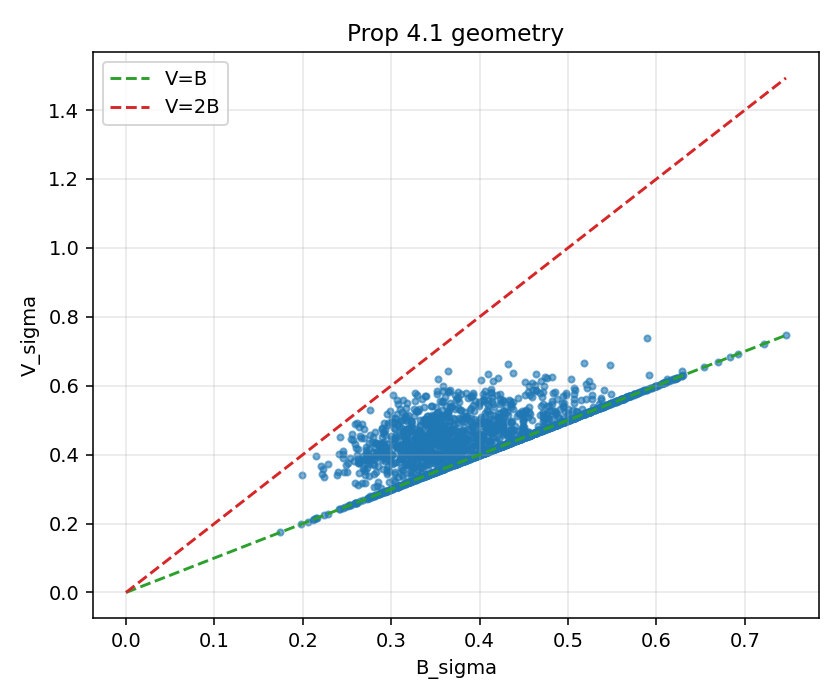

[FIG] prop44_scaling_mode3.png


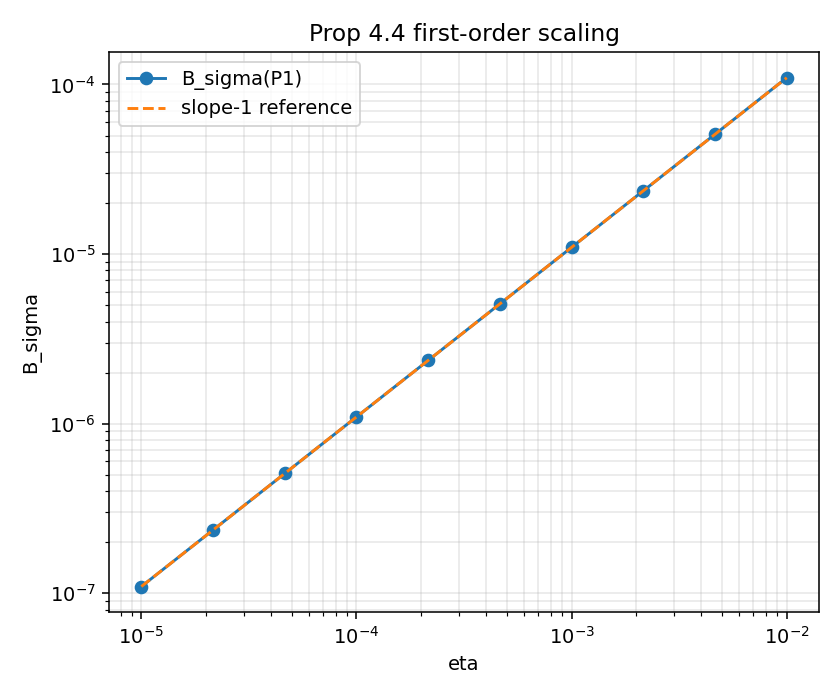

[FIG] prop46_sign_map_mode3.png


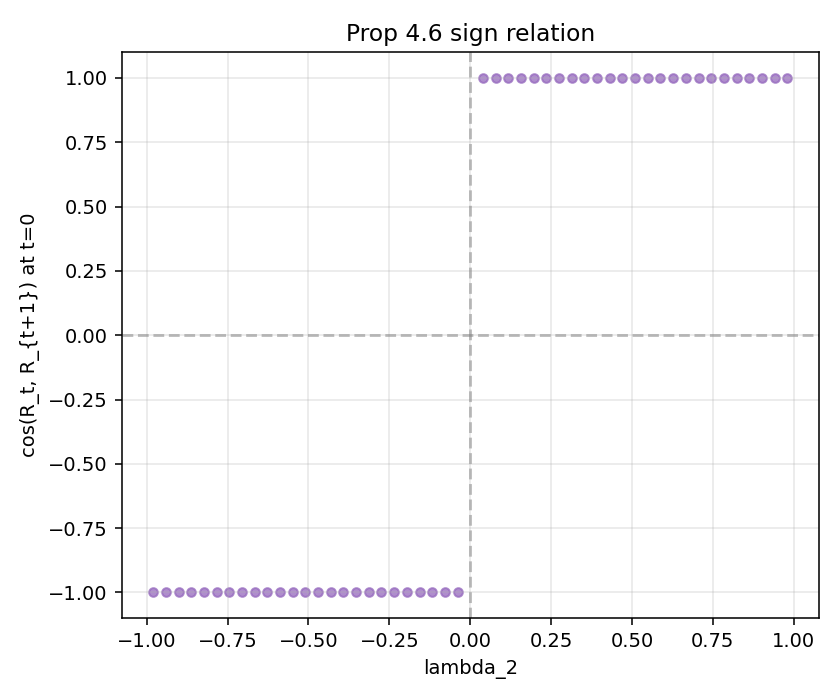

[FIG] prop47_regimes_mode3.png


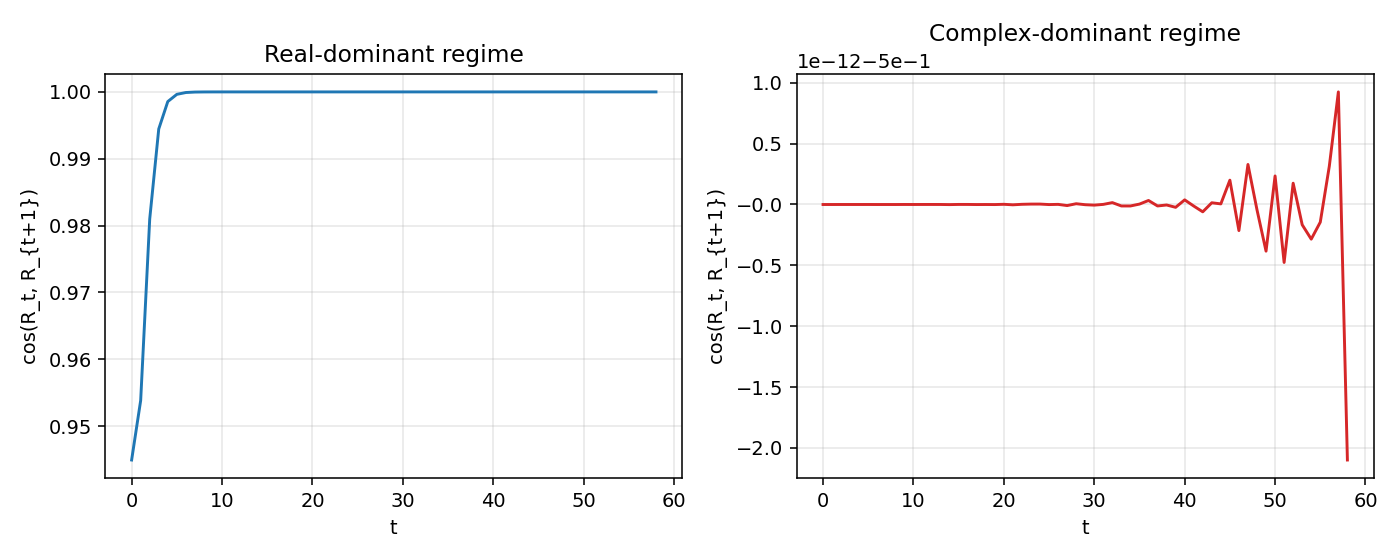

[FIG] supp_active_window_gap_mode3.png


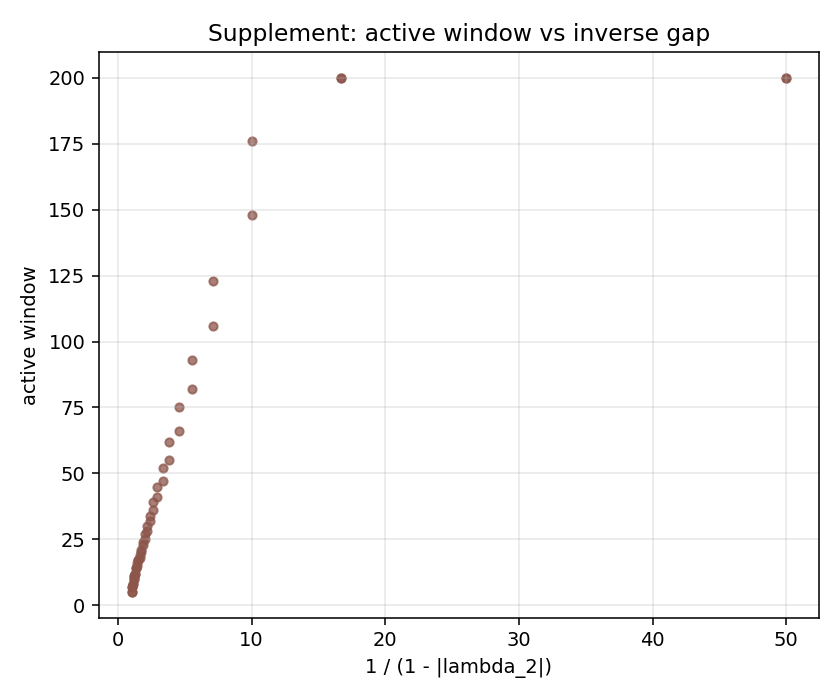

[FIG] boundary_rarity_mode3.png


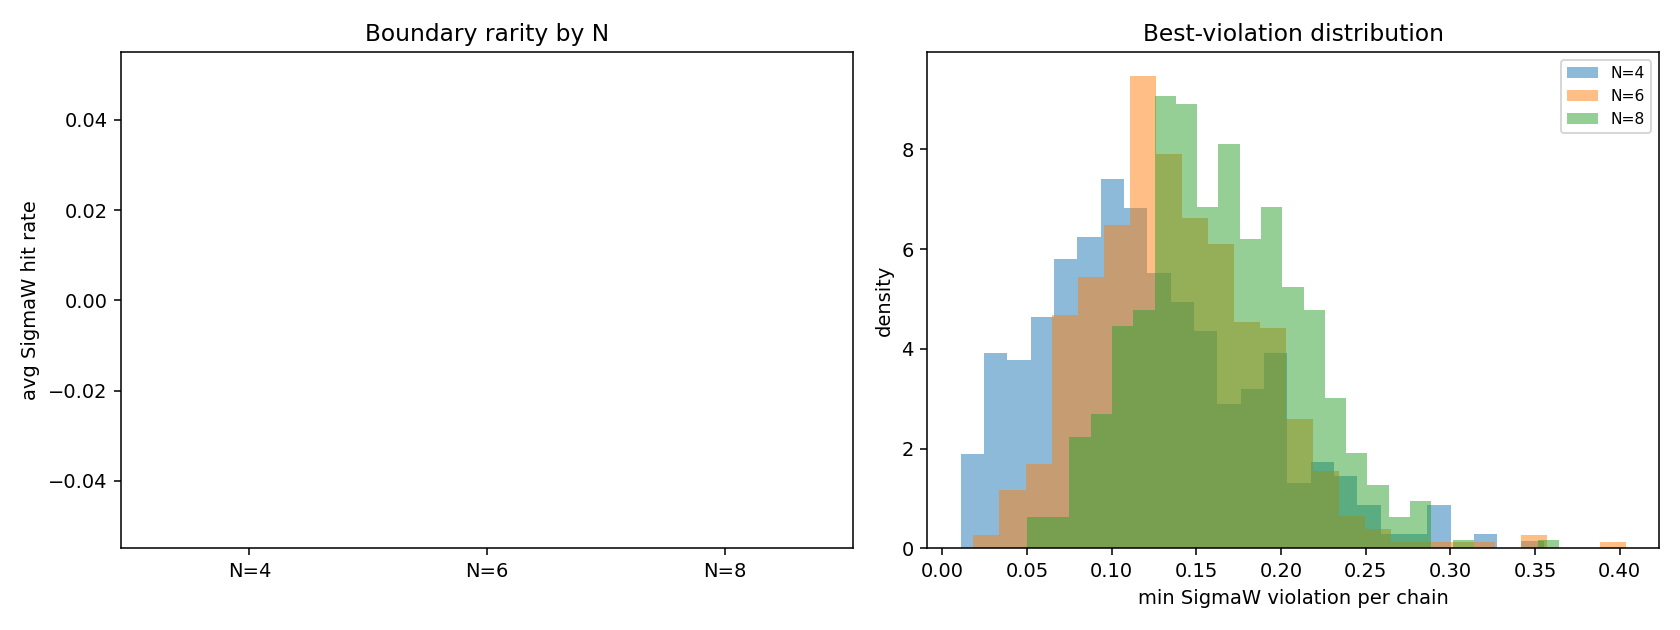

[FIG] near_closure_mode3.png


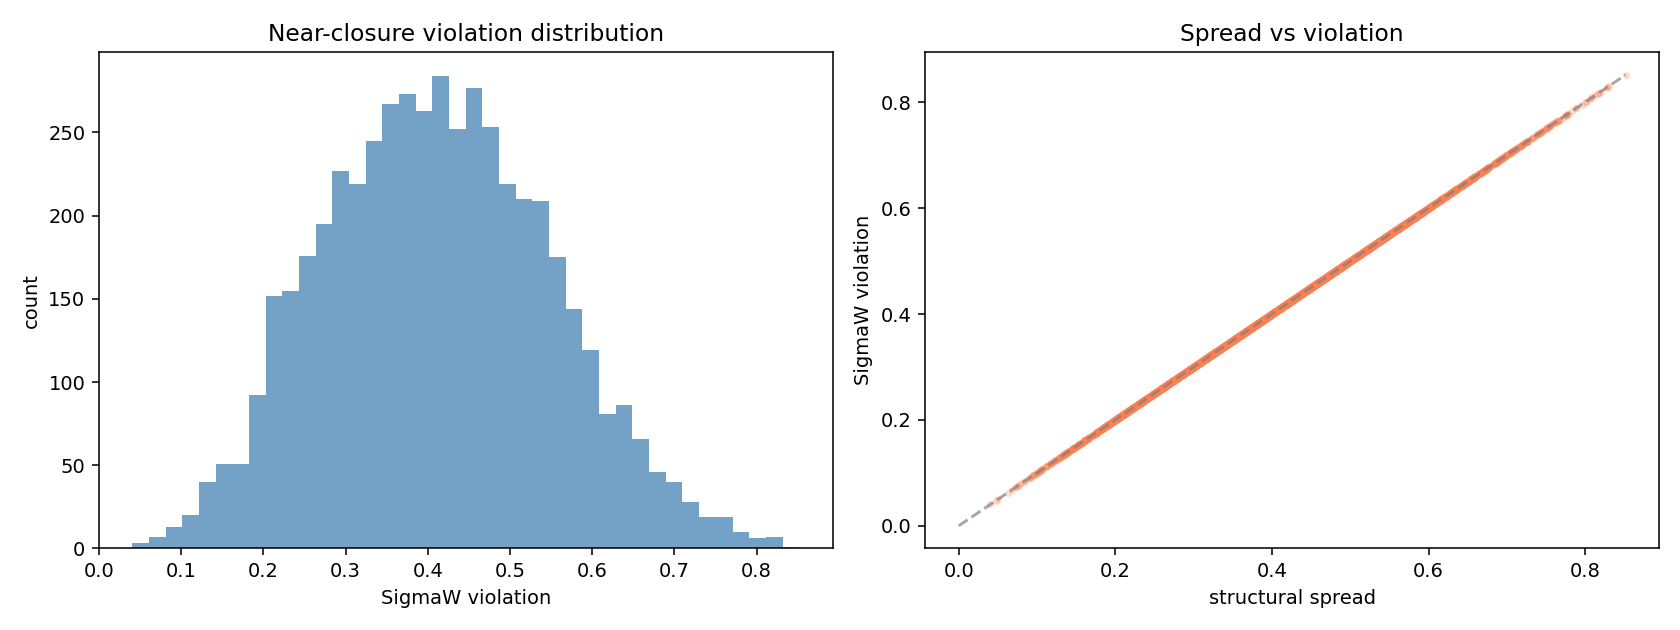

[FIG] perturbation_linearity_mode3.png


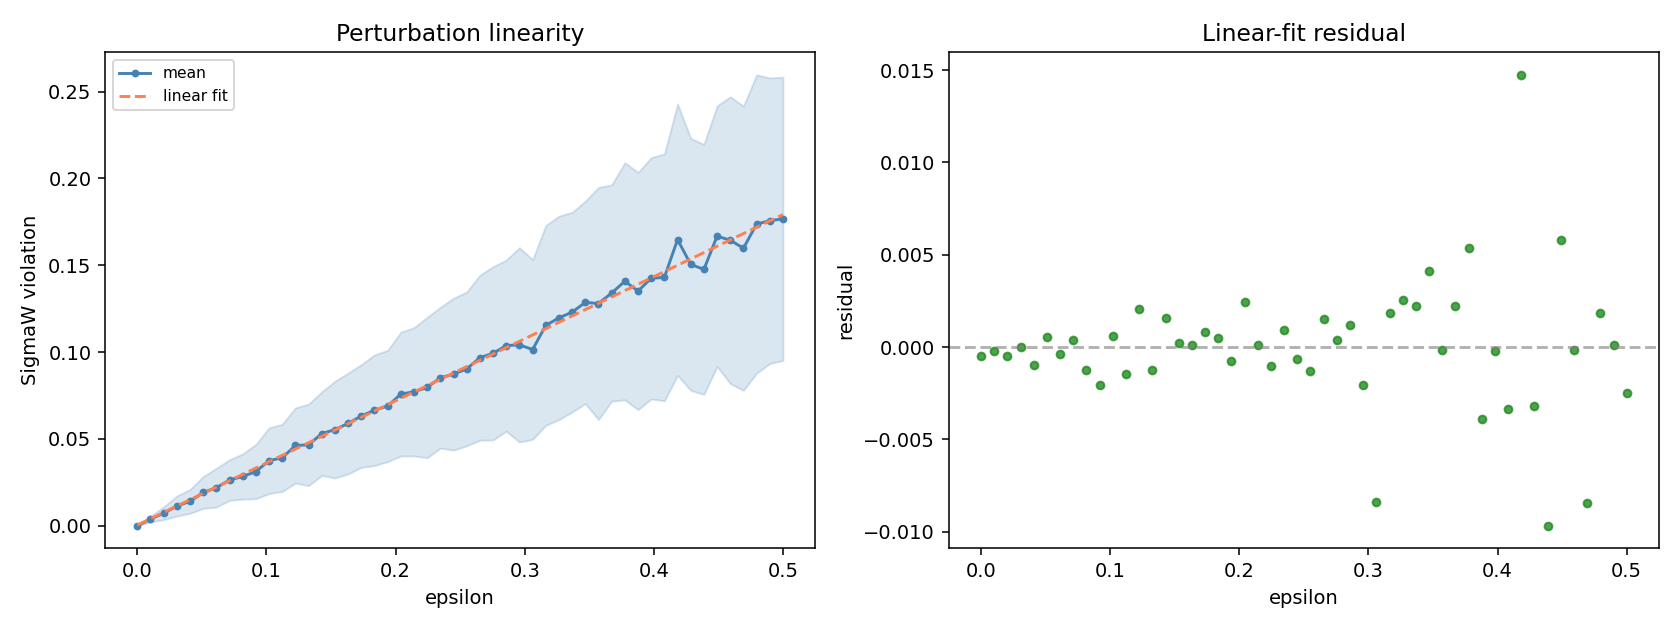

[FIG] d_nbc_interpolation_mode3.png


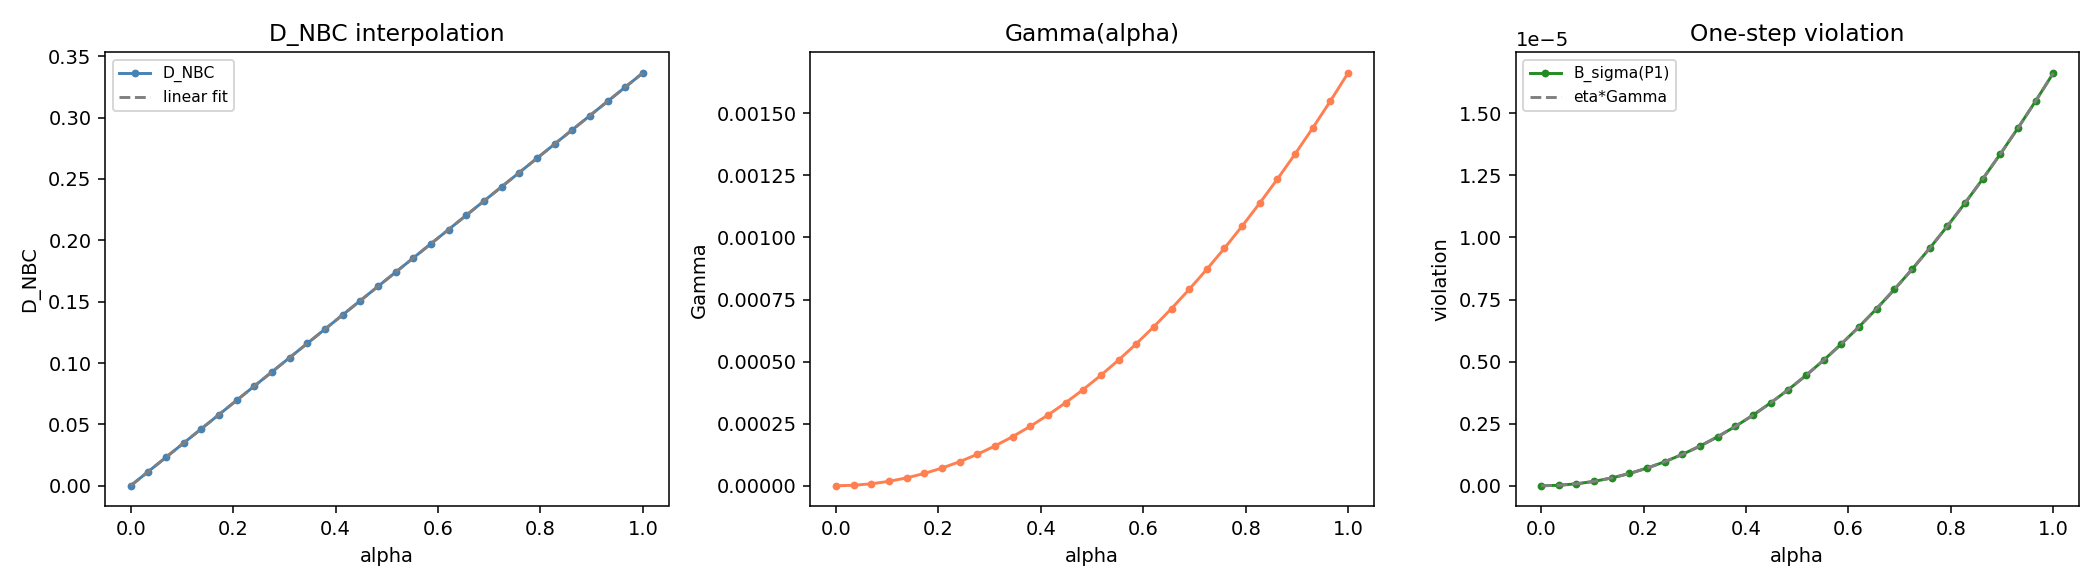

[FIG] gamma_batch_mode3.png


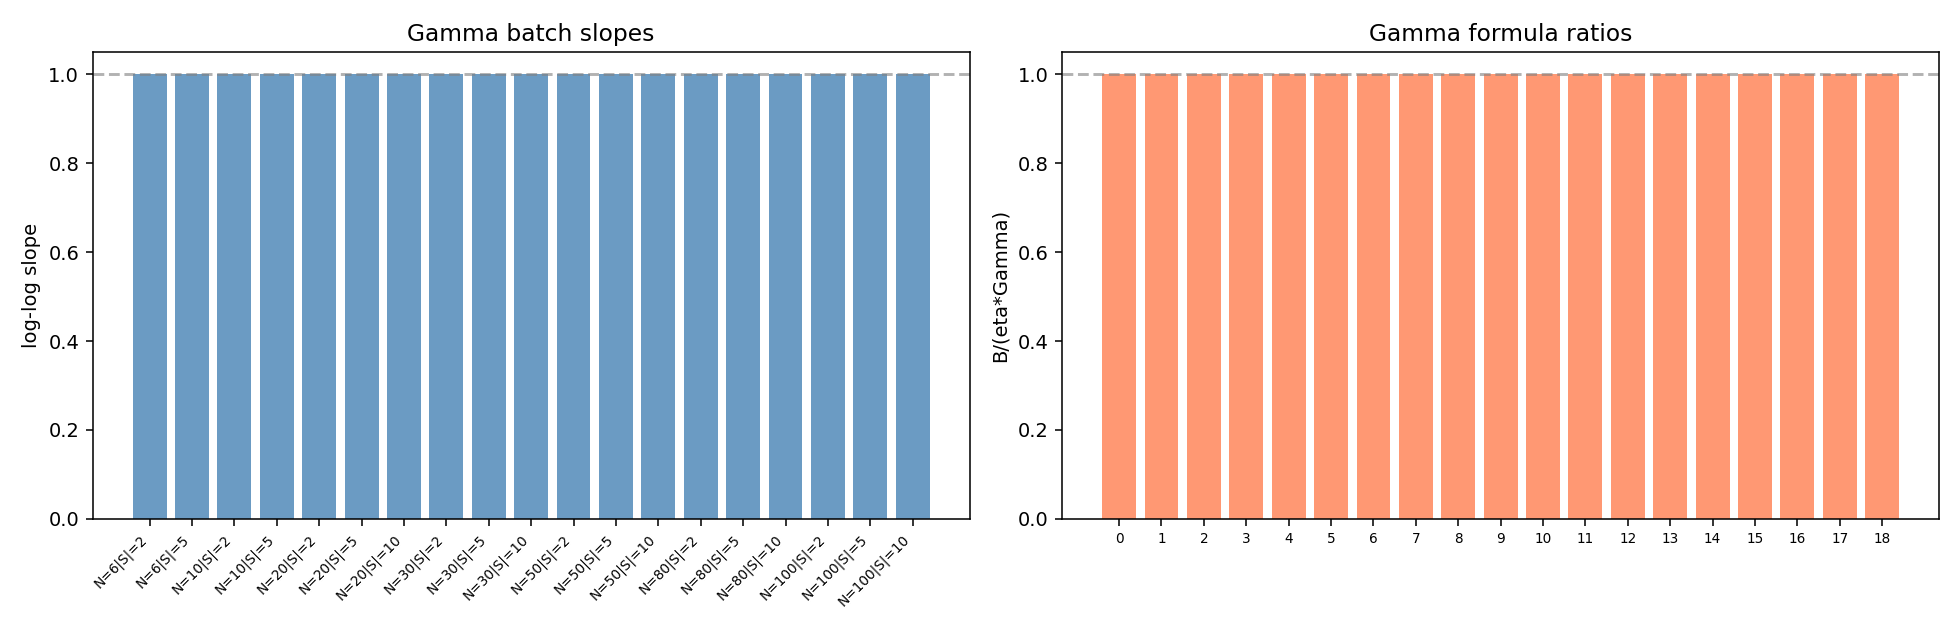

[FIG] sigma_plus_learning_mode3.png


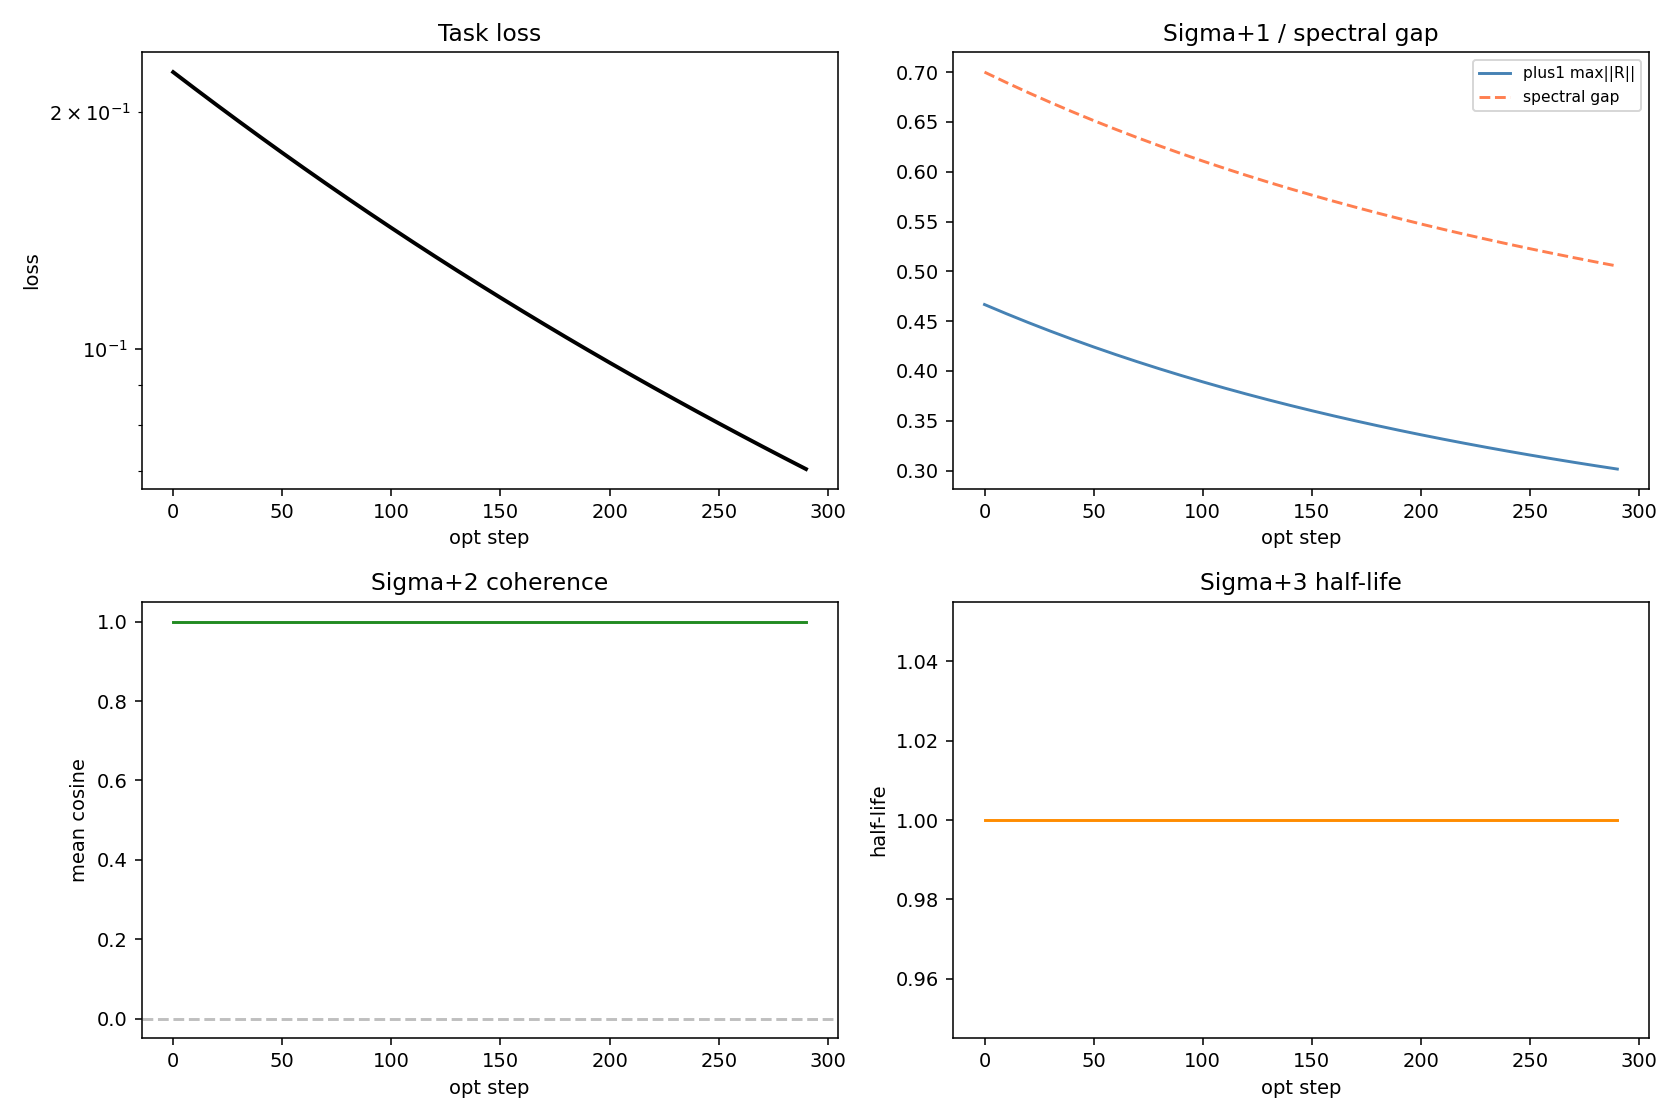

[FIG] discoverability_mode3.png


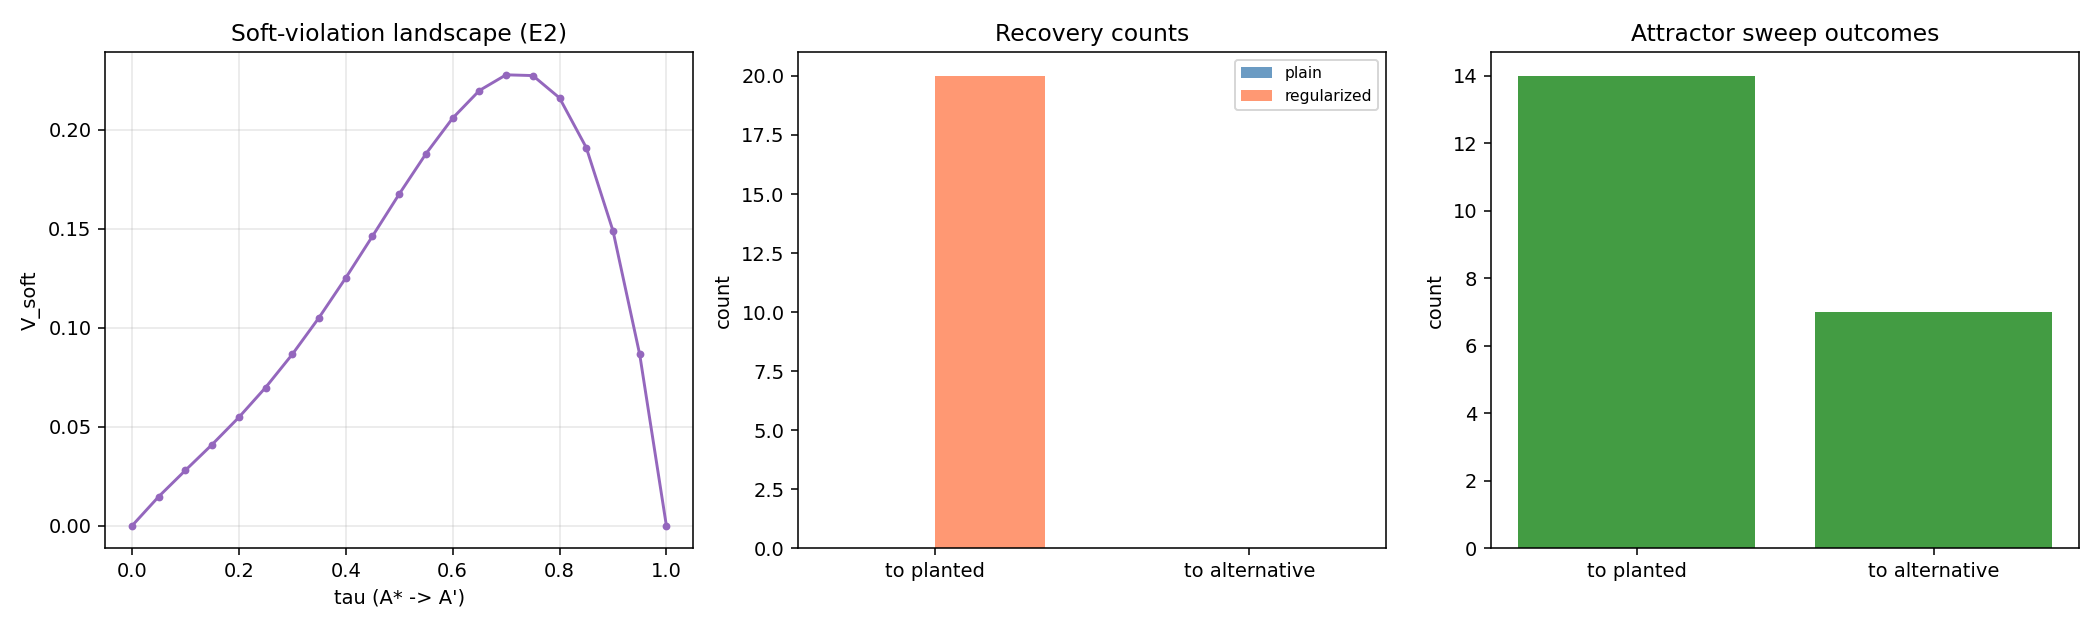

[FIG] scale_summary_mode3.png


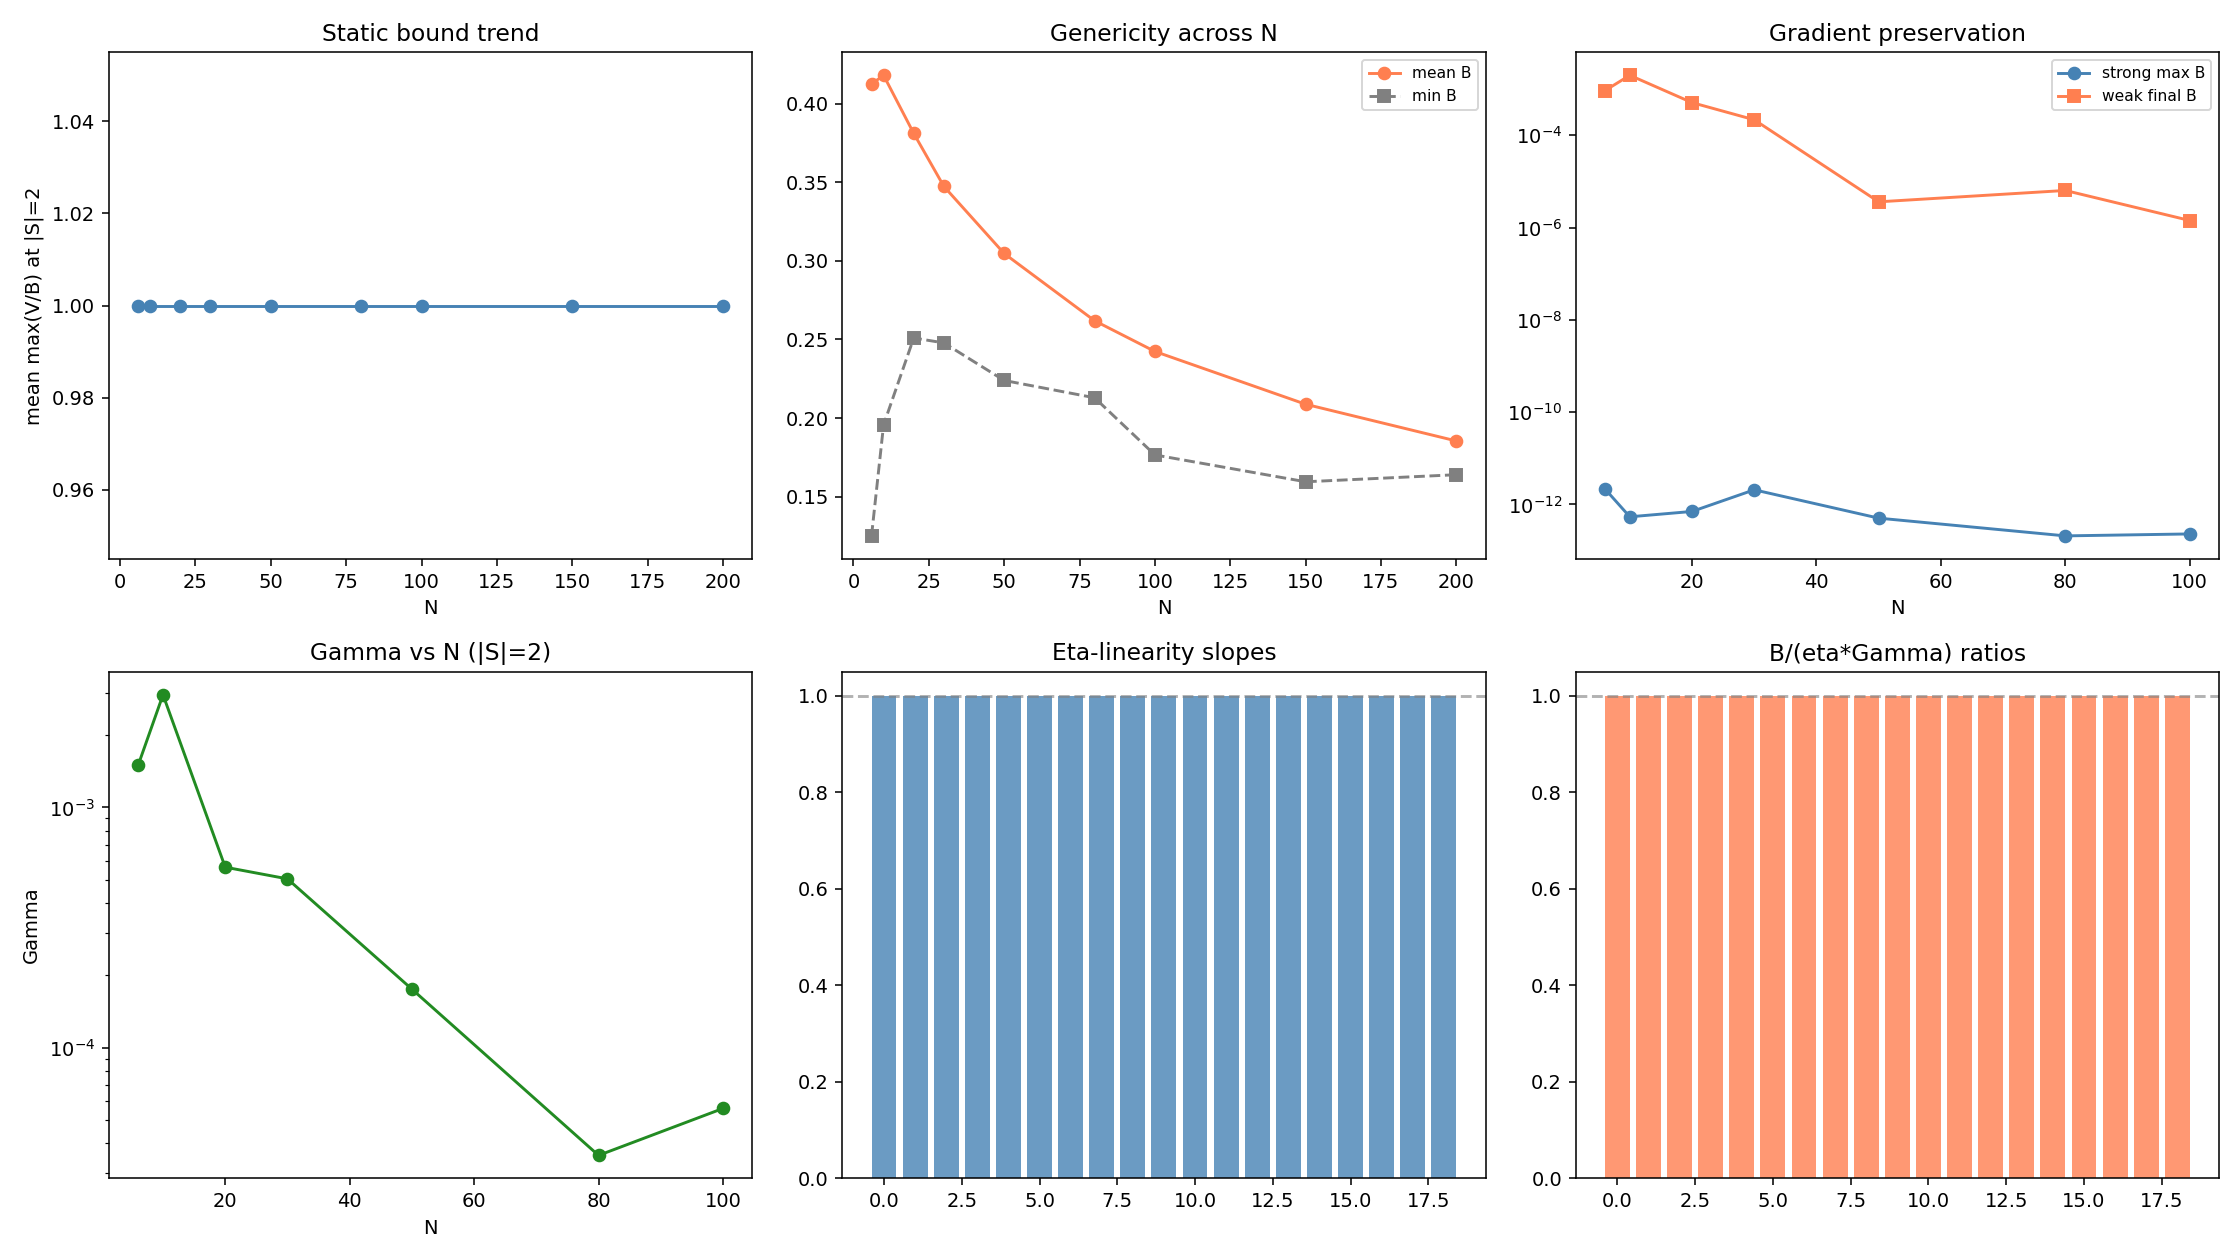

[FIG] doc_claims_mode3.png


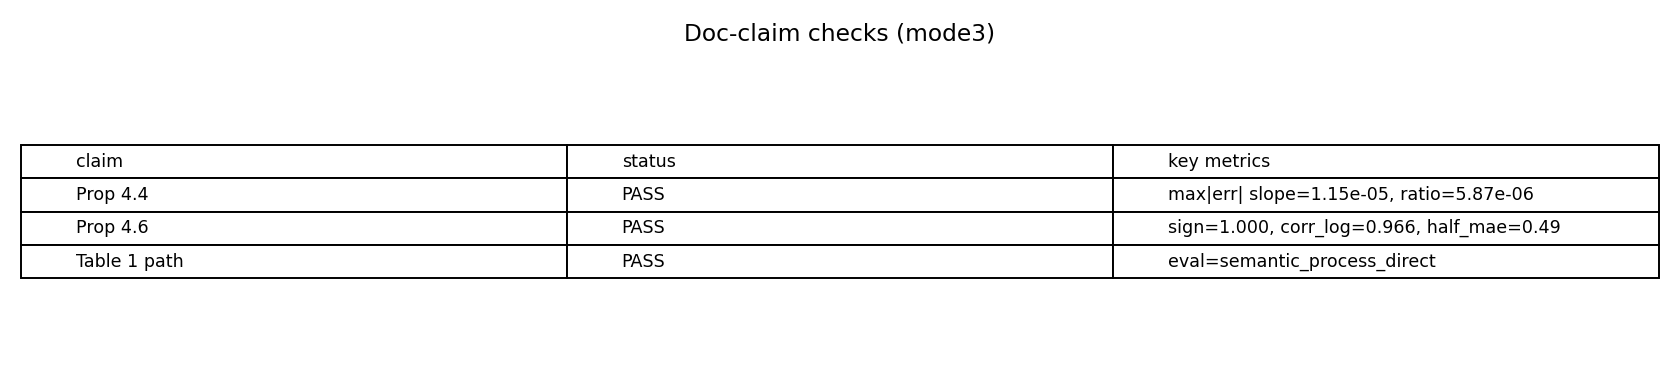

In [43]:
# Display generated figures (requires batch mode: payload = run_profile(...))
from IPython.display import Image, display

if 'payload' not in dir() or not payload.get('artifacts'):
    print('No figures available. Run: payload = run_profile(PROFILE, SEED, plot_enabled=True)')
else:
    for fp in payload['artifacts']:
        p = Path(fp)
        if p.exists():
            print(f"[FIG] {p.name}")
            display(Image(filename=str(p)))
        else:
            print(f"[MISS] {p}")